Notations

We use the following variable names :

....


|Variable| Dataset attribute name |Definition | 
|:-|  :-|:- |
|src|source | ... |
|fp|flux points | ... |


<a id='intro'></a>
## Indice
* [**1. Introduction**](#gammapy)

* [**2. Setup**](#setup)
* [**3. Data Access and Selection (DL3)**](#3.0)
    * [**3.1 Gammapy Catalogs**](#3.1)
    * [**3.2 LHASSO Data Published in the Nature**](#3.2)
* [**4. Analysis**](#4)
    * [**4.1 LHAASO J1825-1326: HESS 1825-137**](#4.1)
    * [**4.2 LHAASO J1825-1326: HESS 1825-130**](#4.2)

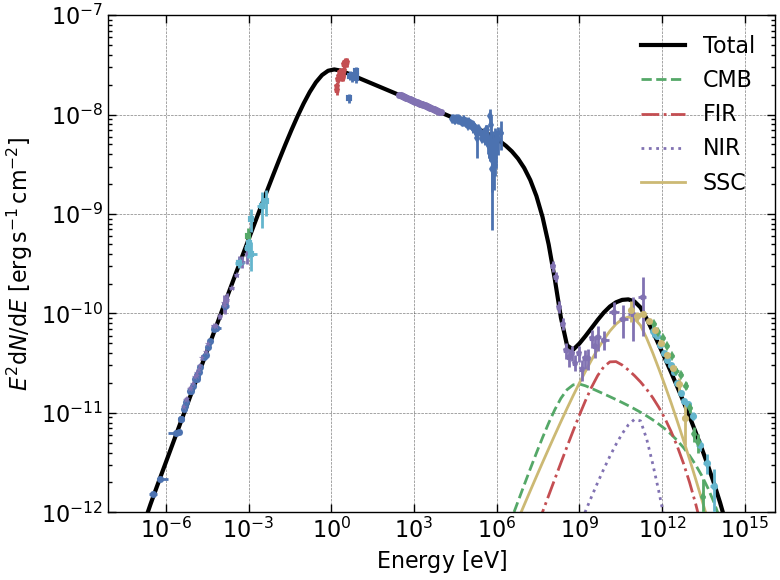

In [63]:
import astropy.units as u
import numpy as np
from astropy.constants import c
from astropy.io import ascii

import naima
from naima.models import (
    ExponentialCutoffBrokenPowerLaw,
    InverseCompton,
    Synchrotron,
)

ECBPL = ExponentialCutoffBrokenPowerLaw(
    amplitude=3.699e36 / u.eV,
    e_0=1 * u.TeV,
    e_break=0.265 * u.TeV,
    alpha_1=1.5,
    alpha_2=3.233,
    e_cutoff=1863 * u.TeV,
    beta=2.0,
)

eopts = {"Eemax": 50 * u.PeV, "Eemin": 0.1 * u.GeV}

SYN = Synchrotron(ECBPL, B=125 * u.uG, Eemax=50 * u.PeV, Eemin=0.1 * u.GeV)

# Compute photon density spectrum from synchrotron emission assuming R=2.1 pc
Rpwn = 2.1 * u.pc
Esy = np.logspace(-7, 9, 100) * u.eV
Lsy = SYN.flux(Esy, distance=0 * u.cm)  # use distance 0 to get luminosity
phn_sy = Lsy / (4 * np.pi * Rpwn ** 2 * c) * 2.24

IC = InverseCompton(
    ECBPL,
    seed_photon_fields=[
        "CMB",
        ["FIR", 70 * u.K, 0.5 * u.eV / u.cm ** 3],
        ["NIR", 5000 * u.K, 1 * u.eV / u.cm ** 3],
        ["SSC", Esy, phn_sy],
    ],
    Eemax=50 * u.PeV,
    Eemin=0.1 * u.GeV,
)

# Use plot_data from naima to plot the observed spectra
data = ascii.read("CrabNebula_spectrum.ecsv")
figure = naima.plot_data(data, e_unit=u.eV)
ax = figure.axes[0]

# Plot the computed model emission
energy = np.logspace(-7, 15, 100) * u.eV
ax.loglog(
    energy,
    IC.sed(energy, 2 * u.kpc) + SYN.sed(energy, 2 * u.kpc),
    lw=3,
    c="k",
    label="Total",
)
for i, seed, ls in zip(
    range(4), ["CMB", "FIR", "NIR", "SSC"], ["--", "-.", ":", "-"]
):
    ax.loglog(
        energy,
        IC.sed(energy, 2 * u.kpc, seed=seed),
        lw=2,
        c=naima.plot.color_cycle[i + 1],
        label=seed,
        ls=ls,
    )


ax.set_ylim(1e-12, 1e-7)
ax.legend(loc="upper right", frameon=False)
figure.tight_layout()
figure.savefig("CrabNebula_SynSSC.png")

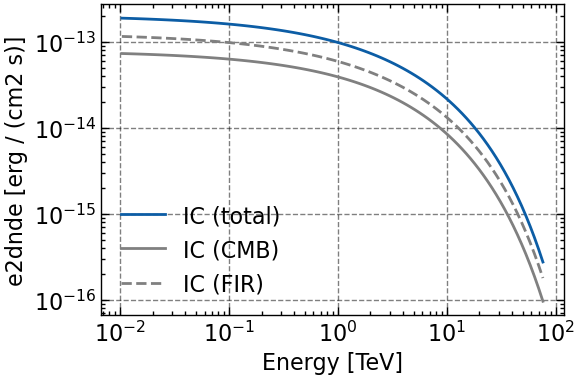

In [72]:
from astropy import units as u
import matplotlib.pyplot as plt
import naima
from gammapy.modeling.models import Models, NaimaSpectralModel, SkyModel

plt.style.use(['science', 'notebook'])

particle_distribution = naima.models.ExponentialCutoffPowerLaw(
    1e30 / u.eV, 10 * u.TeV, 3.0, 30 * u.TeV
)
radiative_model = naima.radiative.InverseCompton(
    particle_distribution,
    seed_photon_fields=["CMB", ["FIR", 26.5 * u.K, 0.415 * u.eV / u.cm**3]],
    Eemin=100 * u.GeV,
)

model = NaimaSpectralModel(radiative_model, distance=1.5 * u.kpc)

plt.figure(figsize=(6,4))
opts = {
    "energy_bounds": [10 * u.GeV, 80 * u.TeV],
    "sed_type": "e2dnde",
    "linewidth": 2
}

# Plot the total inverse Compton emission
model.plot(label="IC (total)", **opts)

# Plot the separate contributions from each seed photon field
for seed, ls in zip(["CMB", "FIR"], ["-", "--"]):
    model = NaimaSpectralModel(radiative_model, seed=seed, distance=1.5 * u.kpc)
    model.plot(label=f"IC ({seed})", ls=ls, color="gray", **opts)
plt.tight_layout()
plt.legend(loc="best")
figure.savefig("naima.png")

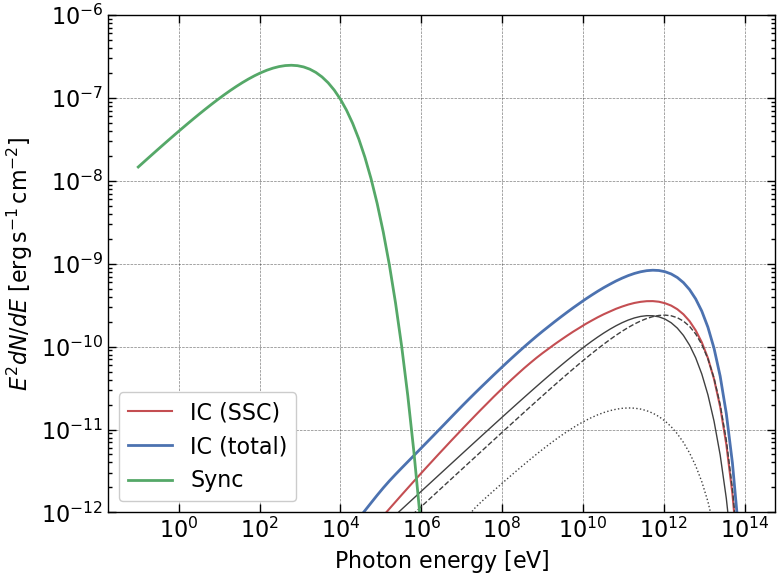

In [66]:
import naima
from naima.models import (ExponentialCutoffPowerLaw, Synchrotron,
                          InverseCompton)
from astropy.constants import c
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

ECPL = ExponentialCutoffPowerLaw(1e36*u.Unit('1/eV'), 1*u.TeV, 2.1, 13*u.TeV)
SYN = Synchrotron(ECPL, B=100*u.uG)

# Define energy array for synchrotron seed photon field and compute
# Synchroton luminosity by setting distance to 0.
Esy = np.logspace(-6, 6, 100)*u.eV
Lsy = SYN.flux(Esy, distance=0*u.cm)

# Define source radius and compute photon density
R = 2 * u.pc
phn_sy = Lsy / (4 * np.pi * R**2 * c) * 2.26

# Create IC instance with CMB and synchrotron seed photon fields:
IC = InverseCompton(ECPL, seed_photon_fields=['CMB', 'FIR', 'NIR',
                                              ['SSC', Esy, phn_sy]])

# Compute SEDs
spectrum_energy = np.logspace(-1,14,100)*u.eV
sed_IC = IC.sed(spectrum_energy, distance=1.5*u.kpc)
sed_SYN = SYN.sed(spectrum_energy, distance=1.5*u.kpc)

# Plot
plt.figure(figsize=(8,5))
plt.rc('font', family='sans')
plt.rc('mathtext', fontset='custom')
ssc = IC.sed(spectrum_energy, seed='SSC', distance=1.5*u.kpc)
plt.loglog(spectrum_energy,ssc,lw=1.5,
        ls='-',label='IC (SSC)',c=naima.plot.color_cycle[2])
for seed, ls in zip(['CMB','FIR','NIR'], ['-','--',':']):
    sed = IC.sed(spectrum_energy, seed=seed, distance=1.5*u.kpc)
    plt.loglog(spectrum_energy,sed,lw=1,
            ls=ls,c='0.25')#,label='IC ({0})'.format(seed))

plt.loglog(spectrum_energy,sed_IC,lw=2,
        label='IC (total)',c=naima.plot.color_cycle[0])
plt.loglog(spectrum_energy,sed_SYN,lw=2,label='Sync',c=naima.plot.color_cycle[1])
plt.xlabel('Photon energy [{0}]'.format(
        spectrum_energy.unit.to_string('latex_inline')))
plt.ylabel('$E^2 dN/dE$ [{0}]'.format(
        sed_SYN.unit.to_string('latex_inline')))
plt.ylim(1e-12, 1e-6)
plt.tight_layout()
plt.legend(loc='lower left')

<a id='setup'></a>
🔝 [Back to Top](#intro)<br>
## 2. Setup 

In [1]:
from gammapy.utils.check import check_tutorials_setup
from gammapy.visualization.utils import plot_contour_line

check_tutorials_setup()


System:

	python_executable      : /home/gamma/anaconda3/envs/gammapy-1.0.1/bin/python 
	python_version         : 3.9.16     
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.0.1      
	path                   : /home/gamma/anaconda3/envs/gammapy-1.0.1/lib/python3.9/site-packages/gammapy 


Other packages:

	numpy                  : 1.24.2     
	scipy                  : 1.10.1     
	astropy                : 5.1.1      
	regions                : 0.7        
	click                  : 8.1.3      
	yaml                   : 6.0        
	IPython                : 8.7.0      
	jupyterlab             : 3.5.3      
	matplotlib             : 3.7.1      
	pandas                 : 1.5.2      
	healpy                 : 1.16.1     
	iminuit                : 2.20.0     
	sherpa                 : 4.15.0     
	naima                  : 0.10.0     
	emcee                  : 3.1.3      
	corner                 : 2.2.1      


Gammap

In [2]:
# !pip install dataframe-image

In [3]:
# !pip install tabulate

In [4]:
# # to install the latest commit (from GitHub)
# !pip install git+https://github.com/garrettj403/SciencePlots

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
import scienceplots

In [7]:
# Making plots actually look nice
plt.style.use(['science', 'notebook', 'grid'])

In [8]:
# plt.style.available

In [9]:
from gammapy.datasets import FluxPointsDataset, Datasets
from gammapy.catalog import CATALOG_REGISTRY

In [10]:
import os
import sys
import importlib

modules_path = '../modules'

module_path = os.path.abspath(f'{modules_path}/spectral_models')
if module_path not in sys.path:
    sys.path.append(module_path)

import spectral_models
importlib.reload(spectral_models)
from spectral_models import pwl_model, get_source_data

module_path = os.path.abspath(f'{modules_path}/utilities')
if module_path not in sys.path:
    sys.path.append(module_path)

import utilities
importlib.reload(utilities)
from utilities import mkdir_sub_directory

In [11]:
from astropy import units as u

from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    SuperExpCutoffPowerLaw4FGLDR3SpectralModel,
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
)

In [12]:
def source_identification(source_index = None):
    '''
    To write Docstring!!!!
    '''
    try: 
        
        global PeVatron_name, PeVatron_txt 
        
        PeVatron_name = df_fp["PeVatron_name"][source_index]
        PeVatron_txt = df_fp["PeVatron_txt"][source_index]
        
        global counterpart_name, counterpart_txt
        
        counterpart_name = df_fp["counterpart_name"][source_index]
        counterpart_txt = df_fp["counterpart_txt"][source_index] 
    
    except:
        print("Oops!  That was no valid index.  Try again...")

In [13]:
# for i, dict_key in enumerate(list(dict_TeV_counterparts.keys())):
#     print(dict_key)

In [14]:
# source = catalog_hgps['HESS J1826-130']


In [15]:
# source.data.

In [16]:
# PeVatron_name ='LHAASO J1825-1326'
# dict_TeV_counterparts[PeVatron_name]

In [17]:
# import pandas library as pd

import pandas as pd 
from gammapy.datasets import FluxPointsDataset
from gammapy.catalog import CATALOG_REGISTRY
import os
import sys

format_csv = ".csv"
format_fits = ".fits"

sed_type="e2dnde"
# sed_type="dnde"

df_columns=[]
datasets_fp = []
sources_catalogs = []
  
# create an Empty DataFrame object
df = pd.DataFrame()


def getting_source_data(dict_TeV_counterparts = None, catalogs_tags = None):
    '''
    To write Docstring!!!!
    '''
    
#     LHAASO_range = range(len())
    for PeVatron_name in list(dict_TeV_counterparts.keys()):
#     for i in LHAASO_range:

#         PeVatron_name = dict_key[i]
        PeVatron_txt = PeVatron_name.replace(" ", "")
        
#         source_range = range(len())
        for counterpart_name in dict_TeV_counterparts[PeVatron_name]:
            
            counterpart_txt = counterpart_name.replace(" ", "")

            catalog_source = []

            catalog_fp = []
            
            source_catalog = []

            dataset_fp = []

#             counterpart_name = dict_TeV_counterparts[PeVatron_name][j]
            
#             catalog_range = range(len(catalogs_tags))
#             for k in catalog_range: 
            for catalog_tag in catalogs_tags:    
#                 catalog_tag = catalogs_tags[k]

                catalog = CATALOG_REGISTRY.get_cls(catalog_tag)()
                
                try:
                    
                    src = catalog[counterpart_name]
                    
                    catalog_source.append(catalog_tag)
                    
                    ds_name = f"{counterpart_name}: {catalog_tag}"
                    ds = FluxPointsDataset(
                        models = src.sky_model(),
                        data=src.flux_points, 
                        name=  ds_name     
                    )
                    
                    source_catalog.append(src)
                    dataset_fp.append(ds)
                    catalog_fp.append(catalog_tag)

                    table = ds.data.to_table(
                        sed_type = sed_type, 
                        formatted = True
                    )
                    
                    # Setting the units
                    
                    # Writes the flux points table in the fits format
                    file_name = f'{PeVatron_txt}_{counterpart_txt}_{catalog_tag}{format_fits}'
                    path_os = os.path.abspath(
                        os.path.join(
                            f"{path_flux_points_tables}/{file_name}"
                        )
                    )      
                    
                    if path_os not in sys.path:
                        sys.path.append(path_os)

                    table.write(
                        f"{path_os}",
                        format = 'fits', 
                        overwrite = True
                    )
                    
                    # Writes the flux points table in the csv format
                    file_name = f'{PeVatron_txt}_{counterpart_txt}_{catalog_tag}{format_csv}'
                    path_os = os.path.abspath(
                        os.path.join(
                            f"{path_flux_points_tables}/{file_name}"
                        )
                    )
                     
                    if path_os not in sys.path:
                        sys.path.append(path_os)

                    table.write(
                        f"{path_os}",
                        format = 'ascii.ecsv', 
                        overwrite = True
                    )   
                    
                except:
                    pass

                df_columns_source = [PeVatron_name, PeVatron_txt, counterpart_name, counterpart_txt, catalog_source, catalog_fp]
            df_columns.append(df_columns_source)
            datasets_fp.append(dataset_fp)
            sources_catalogs.append(source_catalog)

    df = pd.DataFrame(df_columns, columns = ['PeVatron_name', "PeVatron_txt",'counterpart_name', "counterpart_txt", 'catalog', 'flux_points']) 
    df_fp = df[df["flux_points"].str.len() != 0]
    df_fp = df_fp.reset_index(drop = True)
    df_fp.index.name = 'counterpart_index'
    
    file_name = "data_frame_flux_points.csv"
    path_file = f"{os.getcwd()}/{file_name}"
    df_fp.to_csv(path_file, index = "True" )
    
    df_no_fp = df[df["flux_points"].str.len() == 0]
    df_no_fp = df_no_fp.reset_index(drop = True)
    df_no_fp.index.name = df_fp.index.name
    
    file_name = "data_frame_no_flux_points.csv"
    path_file = f"{os.getcwd()}/{file_name}"
    df_no_fp.to_csv(path_file, index = "True")
    print(f"Sources without flux points table: {list(df_no_fp['counterpart_name'])}")
    
    sources_catalogs[:] = list(filter(None, sources_catalogs))
    datasets_fp[:] = list(filter(None, datasets_fp))
    
    return df_fp, datasets_fp, sources_catalogs

In [18]:
# from pandas import read_csv

# myData = read_csv(f"{os.getcwd()}/data_frame_flux_points.csv", index_col = None)
# myData

In [19]:
# to get the current working directory
directory = os.getcwd()

print(directory)

/home/gamma/Documents/GitHub/gammapy/gammapy-notebooks/1.0.1/my_simulations/PSR_J1826−1334/data_access_and_selection(DL3)


In [20]:
import os

In [21]:
path_DL3 = os.getcwd()
os.chdir('../')
path_LHAASO = os.getcwd()
os.chdir(path_DL3)

file_name = "paths.dat"
path_file = f"{path_LHAASO}/{file_name}"
    
with open(path_file, "w") as my_file: 
    my_file.write(f"{path_LHAASO} \n")
    my_file.write(f"{path_file} \n")
    my_file.write(f"{path_DL3} \n")

In [22]:
# path_file

In [23]:
# f"{os.getcwd()}/data_frame_no_flux_points.csv"

<a id='3.0'></a>
🔝 [Back to Top](#intro)<br>
## 3. Data Access and Selection (DL3) 

<a id='3.1'></a>
🔝 [Back to Top](#intro)<br>
#### 3.1 Gammapy Catalogs
Loading the catalogs and sources to be studied

In [24]:
print(CATALOG_REGISTRY)

Registry
--------

SourceCatalogGammaCat: gamma-cat 
SourceCatalogHGPS    : hgps 
SourceCatalog2HWC    : 2hwc 
SourceCatalog3FGL    : 3fgl 
SourceCatalog4FGL    : 4fgl 
SourceCatalog2FHL    : 2fhl 
SourceCatalog3FHL    : 3fhl 
SourceCatalog3HWC    : 3hwc 



In [25]:
catalogs_tags = ["gamma-cat", "hgps", "2hwc", "3hwc", "3fgl", "4fgl", "2fhl", "3fhl"] 

In [26]:
# Loading the source catalogs
catalogs_cls = []
catalog_gammacat = CATALOG_REGISTRY.get_cls(catalogs_tags[0])()
catalogs_cls.append(catalog_gammacat)

catalog_hgps = CATALOG_REGISTRY.get_cls(catalogs_tags[1])()
catalogs_cls.append(catalog_hgps)

catalog_2hwc = CATALOG_REGISTRY.get_cls(catalogs_tags[2])()
catalogs_cls.append(catalog_2hwc)

catalog_3hwc = CATALOG_REGISTRY.get_cls(catalogs_tags[3])()
catalogs_cls.append(catalog_3hwc)

catalog_3fgl = CATALOG_REGISTRY.get_cls(catalogs_tags[4])()
catalogs_cls.append(catalog_3fgl)

catalog_4fgl = CATALOG_REGISTRY.get_cls(catalogs_tags[5])()
catalogs_cls.append(catalog_4fgl)

catalog_2fhl = CATALOG_REGISTRY.get_cls(catalogs_tags[6])()
catalogs_cls.append(catalog_2fhl)

catalog_3fhl = CATALOG_REGISTRY.get_cls(catalogs_tags[7])()
catalogs_cls.append(catalog_3fhl)


In [27]:
for catalog in catalogs_cls:
    print(f"{catalog.tag}: {catalog.description}")

gamma-cat: An open catalog of gamma-ray sources
hgps: H.E.S.S. Galactic plane survey (HGPS) source catalog
2hwc: 2HWC catalog from the HAWC observatory
3hwc: 3HWC catalog from the HAWC observatory
3fgl: LAT 4-year point source catalog
4fgl: LAT 8-year point source catalog
2fhl: LAT second high-energy source catalog
3fhl: LAT third high-energy source catalog


see [gammapy.catalog Package](https://docs.gammapy.org/1.0.1/api-reference/catalog.html)

In [28]:
# help(CATALOG_REGISTRY)

<a id='3.2'></a>
🔝 [Back to Top](#intro)<br>
#### 3.2 Gammapy Catalogs
Loading the catalogs and sources to be studied

In [29]:
# Creating a dictionary of the Potential TeV Counterparts (dict values) 
# of the three most significant (excluding Crab) LHASSO observations (dict keys)
# see https://www.nature.com/articles/s41586-021-03498-z
dict_TeV_counterparts = {
    "LHAASO J1825-1326": ["HESS J1825-137", "HESS J1826-130", "2HWC J1825-134"], 
    "LHAASO J1908+0621": ["MGRO J1908+06" , "HESS J1908+063", "ARGO J1907+0627", "VER J1907+062", "2HWC J1908+063"], 
    "LHAASO J2226+6057": ["VER J2227+608"  , "Boomerang"]
}

In [30]:
# Creating the directories to save the flux points tables from Gammapy catalogs
dir_flux_points_tables = "flux_points_tables"

path_flux_points_tables = mkdir_sub_directory(
    dir_flux_points_tables
)

Directory 'flux_points_tables' created


In [31]:
# Getting the data of the sources from the catalogs of the Gammapy package
df_fp, datasets_fp, sources_catalogs = getting_source_data(dict_TeV_counterparts, catalogs_tags)

Sources without flux points table: ['2HWC J1825-134', '2HWC J1908+063', 'VER J2227+608']


In [32]:
df_fp

,PeVatron_name,PeVatron_txt,counterpart_name,counterpart_txt,catalog,flux_points
counterpart_index,,,,,,
0,LHAASO J1825-1326,LHAASOJ1825-1326,HESS J1825-137,HESSJ1825-137,"[gamma-cat, hgps, 3fgl, 4fgl, 2fhl, 3fhl]","[gamma-cat, hgps, 3fgl, 4fgl, 2fhl, 3fhl]"
1,LHAASO J1825-1326,LHAASOJ1825-1326,HESS J1826-130,HESSJ1826-130,"[gamma-cat, hgps, 4fgl, 3fhl]","[gamma-cat, hgps, 4fgl, 3fhl]"
2,LHAASO J1908+0621,LHAASOJ1908+0621,MGRO J1908+06,MGROJ1908+06,"[gamma-cat, 3fgl, 4fgl]","[gamma-cat, 3fgl, 4fgl]"
3,LHAASO J1908+0621,LHAASOJ1908+0621,HESS J1908+063,HESSJ1908+063,"[gamma-cat, hgps]","[gamma-cat, hgps]"
4,LHAASO J1908+0621,LHAASOJ1908+0621,ARGO J1907+0627,ARGOJ1907+0627,[gamma-cat],[gamma-cat]
5,LHAASO J1908+0621,LHAASOJ1908+0621,VER J1907+062,VERJ1907+062,[gamma-cat],[gamma-cat]
6,LHAASO J2226+6057,LHAASOJ2226+6057,Boomerang,Boomerang,"[3fgl, 4fgl]","[3fgl, 4fgl]"


In [33]:
df_fp[['PeVatron_name','counterpart_name','flux_points']]

,PeVatron_name,counterpart_name,flux_points
counterpart_index,,,
0,LHAASO J1825-1326,HESS J1825-137,"[gamma-cat, hgps, 3fgl, 4fgl, 2fhl, 3fhl]"
1,LHAASO J1825-1326,HESS J1826-130,"[gamma-cat, hgps, 4fgl, 3fhl]"
2,LHAASO J1908+0621,MGRO J1908+06,"[gamma-cat, 3fgl, 4fgl]"
3,LHAASO J1908+0621,HESS J1908+063,"[gamma-cat, hgps]"
4,LHAASO J1908+0621,ARGO J1907+0627,[gamma-cat]
5,LHAASO J1908+0621,VER J1907+062,[gamma-cat]
6,LHAASO J2226+6057,Boomerang,"[3fgl, 4fgl]"


In [34]:
import dataframe_image as dfi
dfi.export(df_fp[['PeVatron_name','counterpart_name','flux_points']], 'df_fp.png')

In [35]:
import numpy as np
import astropy.units as u

# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.catalog import CATALOG_REGISTRY

from pandas import read_csv

In [36]:
counterpart_name = list(dict_TeV_counterparts.values())[0][0]

In [37]:
print(df_fp[['PeVatron_name','counterpart_name','flux_points']].to_latex(index=False)) 

\begin{tabular}{lll}
\toprule
    PeVatron\_name & counterpart\_name &                               flux\_points \\
LHAASO J1825-1326 &   HESS J1825-137 & [gamma-cat, hgps, 3fgl, 4fgl, 2fhl, 3fhl] \\
\midrule
LHAASO J1825-1326 &   HESS J1826-130 &             [gamma-cat, hgps, 4fgl, 3fhl] \\
LHAASO J1908+0621 &    MGRO J1908+06 &                   [gamma-cat, 3fgl, 4fgl] \\
LHAASO J1908+0621 &   HESS J1908+063 &                         [gamma-cat, hgps] \\
LHAASO J1908+0621 &  ARGO J1907+0627 &                               [gamma-cat] \\
LHAASO J1908+0621 &    VER J1907+062 &                               [gamma-cat] \\
LHAASO J2226+6057 &        Boomerang &                              [3fgl, 4fgl] \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1131007/4175010442.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_fp[['PeVatron_name','counterpart_name','flux_points']].to_latex(index=False))


In [38]:

df_no_pf = read_csv(f"{os.getcwd()}/data_frame_no_flux_points.csv", index_col = 'counterpart_index')
df_no_pf

,PeVatron_name,PeVatron_txt,counterpart_name,counterpart_txt,catalog,flux_points
counterpart_index,,,,,,
0,LHAASO J1825-1326,LHAASOJ1825-1326,2HWC J1825-134,2HWCJ1825-134,['2hwc'],[]
1,LHAASO J1908+0621,LHAASOJ1908+0621,2HWC J1908+063,2HWCJ1908+063,['2hwc'],[]
2,LHAASO J2226+6057,LHAASOJ2226+6057,VER J2227+608,VERJ2227+608,[],[]


In [39]:
print(df_no_pf[['PeVatron_name','counterpart_name', 'catalog']].to_latex(index=False)) 

\begin{tabular}{lll}
\toprule
    PeVatron\_name & counterpart\_name &  catalog \\
LHAASO J1825-1326 &   2HWC J1825-134 & ['2hwc'] \\
\midrule
LHAASO J1908+0621 &   2HWC J1908+063 & ['2hwc'] \\
LHAASO J2226+6057 &    VER J2227+608 &       [] \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1131007/3452632965.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_no_pf[['PeVatron_name','counterpart_name', 'catalog']].to_latex(index=False))


In [40]:
dict_TeV_counterparts

{'LHAASO J1825-1326': ['HESS J1825-137', 'HESS J1826-130', '2HWC J1825-134'],
 'LHAASO J1908+0621': ['MGRO J1908+06',
  'HESS J1908+063',
  'ARGO J1907+0627',
  'VER J1907+062',
  '2HWC J1908+063'],
 'LHAASO J2226+6057': ['VER J2227+608', 'Boomerang']}

In [41]:
print(catalog_2fhl["HESS J1825-137"])


*** Basic info ***

Catalog row index (zero-based) : 279
Source name          : 2FHL J1824.5-1350e
Associations     : HESS J1825-137, 3FGL J1824.5-1351e, 1FHL J1824.5-1351e, TeV J1826-130
ASSOC_PROB_BAY   : --
ASSOC_PROB_LR    : --
Class            : pwn
TeVCat flag      : N/A

*** Other info ***

Test statistic (50 GeV - 2 TeV)  : 266.700

*** Position info ***

RA                   : 276.130 deg
DEC                  : -13.850 deg
GLON                 : 17.569 deg
GLAT                 : -0.452 deg

Error on position (68%) : 0.0000 deg
ROI number           : 106

*** Extended source information ***

Model form       : 2D Gaussian
Model semimajor  : 0.7500 deg
Model semiminor  : 0.7500 deg
Position angle   : 90.0000 deg
Spatial filename : HESSJ1825-137.fits


*** Spectral fit info ***

Power-law spectral index         : 1.890 +- 0.110
Integral flux (50 GeV - 2 TeV)   : 7.15e-10 +- 6.46e-11 cm-2 s-1
Energy flux (50 GeV - 2 TeV)     : 2.4e-10 +- 3.2e-11 erg cm-2 s-1

*** Spectral points 

/home/gamma/anaconda3/envs/gammapy-1.0.1/lib/python3.9/site-packages/gammapy/catalog/fermi.py:102: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  ss += "{:<16s} : {:.3f}\n".format("ASSOC_PROB_BAY", d["ASSOC_PROB_BAY"])
/home/gamma/anaconda3/envs/gammapy-1.0.1/lib/python3.9/site-packages/gammapy/catalog/fermi.py:103: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  ss += "{:<16s} : {:.3f}\n".format("ASSOC_PROB_LR", d["ASSOC_PROB_LR"])


In [42]:
PeVatron_name = 'LHAASO J1825-1326'
PeVatron_txt = PeVatron_name.replace(" ", "_")
PeVatron_name, PeVatron_txt

('LHAASO J1825-1326', 'LHAASO_J1825-1326')

In [43]:
from astropy.coordinates import SkyCoord

# source_position
# Cao, Z., Aharonian, F.A., An, Q. et al. Ultrahigh-energy photons up to 1.4 petaelectronvolts from 12 γ-ray Galactic sources. Nature 594, 33–36 (2021). https://doi.org/10.1038/s41586-021-03498-z

src_RA = 276.45 # Right ascension (degrees)
src_dec = -13.45 # Declination (degrees)

source_position = SkyCoord(src_RA, src_dec, unit='deg') 
source_position

<SkyCoord (ICRS): (ra, dec) in deg
    (276.45, -13.45)>

In [44]:
import astropy.units as u

# The angle that defines the region, centered in the LHAASO source position, to search for possible counterparts
angle_reg = 1 * u.deg

In [45]:
import astropy.units as u

catalog_roi = []
for i, catalog in enumerate(catalogs_cls):
#     print(f"{catalog.tag}: {catalog.description}")
    mask_roi = source_position.separation(catalog.positions) < 1 * u.deg
    catalog_roi.append(catalog[mask_roi])
    display(catalog_roi[i].table)
    #print("Number of sources :", len(catalog_roi.table))
#     display(catalog_roi.table)

source_id,common_name,gamma_names,fermi_names,other_names,where,classes,discoverer,seen_by,discovery_date,tevcat_id,tevcat2_id,tevcat_name,tgevcat_id,tgevcat_name,reference_id,significance,livetime,ra,dec,glon,glat,pos_ra,pos_dec,pos_glon,pos_glat,pos_err,morph_type,morph_sigma,morph_sigma_err,morph_sigma2,morph_sigma2_err,morph_pa,morph_pa_err,morph_pa_frame,spec_type,spec_pl_norm,spec_pl_norm_err,spec_pl_norm_err_sys,spec_pl_index,spec_pl_index_err,spec_pl_index_err_sys,spec_pl_e_ref,spec_pl2_flux,spec_pl2_flux_err,spec_pl2_flux_err_sys,spec_pl2_index,spec_pl2_index_err,spec_pl2_index_err_sys,spec_pl2_e_min,spec_pl2_e_max,spec_ecpl_norm,spec_ecpl_norm_err,spec_ecpl_norm_err_sys,spec_ecpl_index,spec_ecpl_index_err,spec_ecpl_index_err_sys,spec_ecpl_e_cut,spec_ecpl_e_cut_err,spec_ecpl_e_cut_err_sys,spec_ecpl_e_ref,spec_erange_min,spec_erange_max,spec_theta,spec_dnde_1TeV,spec_dnde_1TeV_err,spec_flux_1TeV,spec_flux_1TeV_err,spec_flux_1TeV_crab,spec_flux_1TeV_crab_err,spec_eflux_1TeV_10TeV,spec_eflux_1TeV_10TeV_err,sed_reference_id,sed_n_points,sed_n_ul,sed_e_ref,sed_e_min,sed_e_max,sed_dnde,sed_dnde_err,sed_dnde_errp,sed_dnde_errn,sed_dnde_ul
,,,,,,,,,,,,,,,,,h,deg,deg,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,deg,deg,deg,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,,,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,TeV,TeV,TeV,TeV,TeV,TeV,deg,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s),1 / (cm2 s),,,erg / (cm2 s),erg / (cm2 s),,,,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
int32,bytes21,bytes76,bytes72,bytes73,bytes4,bytes11,bytes8,bytes35,bytes7,int64,bytes6,bytes14,int64,bytes14,bytes19,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes5,float32,float32,float32,float32,float32,float32,bytes8,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes19,int32,int32,float32[40],float32[40],float32[40],float32[40],float32[40],float32[40],float32[40],float32[40]
161,HESS J1826-130,HESS J1826-130,--,"PSR J1826-1256,PWN G018.5-00.4",gal,unid,hess,hess,2015-07,271,BpWYND,TeV J1826-130,-9223372036854775808,--,2017arXiv170107002A,21.0,206.0,276.50418,-13.09111,18.409912,-0.41967452,276.50082,-13.033334,18.459501,-0.3898485,0.0295804,gauss,0.17,0.02,--,--,--,--,--,ecpl,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,8.62e-13,7.3e-14,1.72e-13,1.61,0.11,0.2,12.5,4.0,--,1.0,--,--,0.22,7.957263e-13,7.039912e-14,8.987795e-13,1.414763e-13,4.332629,0.6819964,3.658115e-12,6.849412e-13,2017arXiv170107002A,22,1,0.5115 .. --,0.46417 .. --,0.56236 .. --,4e-12 .. --,-- .. --,1.084e-12 .. --,1.037e-12 .. --,-- .. --
118,HESS J1825-137,"HESS J1825-137,1HWC J1825-133",--,"PSR J1826-1334,PSR B1823-13",gal,pwn,hess,"hess,hawc",2005-03,115,xnwQAv,TeV J1826-137,118,TeV J1825-1350,2006A&A...460..365A,33.8,52.1,276.5544,-13.58004,18.00018,-0.69092745,276.42084,-13.839167,17.710417,-0.697004,0.011023964,gauss,0.24,0.02,--,--,--,--,--,ecpl,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,2.1e-11,5e-13,--,2.26,0.03,--,24.8,7.2,--,1.0,0.27,--,0.8,2.017007e-11,5.351485e-13,1.4776536e-11,6.4688684e-13,71.23132,3.1183634,5.0830055e-11,2.7439834e-12,2006A&A...460..365A,11,0,0.277619 .. --,-- .. --,-- .. --,3.4357e-10 .. --,-- .. --,2.25247e-11 .. --,2.25161e-11 .. --,-- .. --


Source_Name,Analysis_Reference,Source_Class,Identified_Object,Gamma_Cat_Source_ID,RAJ2000,DEJ2000,GLON,GLON_Err,GLAT,GLAT_Err,Pos_Err_68,Pos_Err_95,ROI_Number,Spatial_Model,Components,Sqrt_TS,Size,Size_Err,Size_UL,R70,RSpec,Excess_Model_Total,Excess_RSpec,Excess_RSpec_Model,Background_RSpec,Livetime,Energy_Threshold,Flux_Map,Flux_Map_Err,Flux_Map_RSpec_Data,Flux_Map_RSpec_Source,Flux_Map_RSpec_Other,Flux_Map_RSpec_LS,Flux_Map_RSpec_Total,Containment_RSpec,Contamination_RSpec,Flux_Correction_RSpec_To_Total,Livetime_Spec,Energy_Range_Spec_Min,Energy_Range_Spec_Max,Background_Spec,Excess_Spec,Spectral_Model,TS_ECPL_over_PL,Flux_Spec_Int_1TeV,Flux_Spec_Int_1TeV_Err,Flux_Spec_Energy_1_10_TeV,Flux_Spec_Energy_1_10_TeV_Err,Energy_Spec_PL_Pivot,Flux_Spec_PL_Diff_Pivot,Flux_Spec_PL_Diff_Pivot_Err,Flux_Spec_PL_Diff_1TeV,Flux_Spec_PL_Diff_1TeV_Err,Index_Spec_PL,Index_Spec_PL_Err,Energy_Spec_ECPL_Pivot,Flux_Spec_ECPL_Diff_Pivot,Flux_Spec_ECPL_Diff_Pivot_Err,Flux_Spec_ECPL_Diff_1TeV,Flux_Spec_ECPL_Diff_1TeV_Err,Index_Spec_ECPL,Index_Spec_ECPL_Err,Lambda_Spec_ECPL,Lambda_Spec_ECPL_Err,Flux_Spec_PL_Int_1TeV,Flux_Spec_PL_Int_1TeV_Err,Flux_Spec_ECPL_Int_1TeV,Flux_Spec_ECPL_Int_1TeV_Err,N_Flux_Points,Flux_Points_Energy,Flux_Points_Energy_Min,Flux_Points_Energy_Max,Flux_Points_Flux,Flux_Points_Flux_Err_Lo,Flux_Points_Flux_Err_Hi,Flux_Points_Flux_UL,Flux_Points_Flux_Is_UL
,,,,,deg,deg,deg,deg,deg,deg,deg,deg,,,,,deg,deg,deg,deg,deg,,,,,h,TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,,,h,TeV,TeV,,,,,1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),erg / (cm2 s),TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,1 / TeV,1 / TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),
bytes16,bytes6,bytes10,bytes20,bytes7,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes18,bytes103,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32[40],float32[40],float32[40],float32[40],float32[40],float32[40],float32[40],uint8[40]
HESS J1825-137,HGPS,PWN,PSR J1826-1334,118,276.25955,-13.965834,17.525293,0.08188217,-0.6177096,0.011102029,0.12531129,0.20318753,6,3-Gaussian,"HGPSC 065, HGPSC 066, HGPSC 067",76.464096,0.4613328,0.03199799,--,0.70874697,0.5,18291.5,9525.467,9408.828,8608.533,109.093414,0.3962191,1.8408056e-11,5.558961e-13,8.9967166e-12,8.72374e-12,1.214668e-13,1.947474e-13,9.039954e-12,0.47390875,0.034979627,2.0363,12.521725,0.23713738,61.896584,5843.427,3129.5732,ECPL,11.391988,1.9150166e-11,1.846692e-12,6.6403015e-11,7.952373e-12,1.1561109,1.716532e-11,5.731118e-13,2.4232996e-11,8.1239583e-13,2.3770857,0.030754326,0.65012896,6.946258e-11,2.854722e-12,2.5557462e-11,8.9952313e-13,2.1509936,0.06252628,0.0736742,0.021369955,1.7596003e-11,6.662307e-13,1.9150166e-11,1.846692e-12,6,0.3651741 .. --,0.23713738 .. --,0.56234133 .. --,2.3817817e-10 .. --,1.642453e-11 .. --,1.6535958e-11 .. --,2.7151786e-10 .. --,0 .. 0
HESS J1826-130,HGPS,Unid,--,161,276.50873,-13.01738,18.477198,0.027765885,-0.38920334,0.02691068,0.059582993,0.09661158,6,Gaussian,HGPSC 068,9.415467,0.15234366,0.02082743,--,0.24898651,0.24898651,453.77756,541.79956,517.12085,1100.2004,83.22165,0.3962191,8.60917e-13,1.6662851e-13,9.571046e-13,6.0395677e-13,3.2579706e-13,8.9815694e-14,1.0195695e-12,0.70152724,0.40763554,0.84439266,7.040914,0.21544346,82.54042,774.3197,138.68028,PL,--,1.1410672e-12,1.6042182e-13,4.188119e-12,6.062467e-13,2.0558882,2.727714e-13,3.777238e-14,1.1836815e-12,1.8693714e-13,2.0365

source_name,ra,dec,glon,glat,pos_err,search_radius,ts,spec0_dnde,spec0_dnde_err,spec0_index,spec0_index_err,spec0_radius,spec1_dnde,spec1_dnde_err,spec1_index,spec1_index_err,spec1_radius
,deg,deg,deg,deg,deg,deg,,1 / (cm2 s TeV),1 / (cm2 s TeV),,,deg,1 / (cm2 s TeV),1 / (cm2 s TeV),,,deg
str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2HWC J1825-134,276.460,-13.401,18.115,-0.526,0.086,0.0,767.3,1.38e-13,8.1e-15,-2.58,0.04,0.000,2.49e-13,1.14e-14,-2.56,0.03,0.900


source_name,ra,dec,glon,glat,pos_err,search_radius,ts,spec0_dnde,spec0_dnde_errn,spec0_dnde_errp,spec0_dnde_sys_errn,spec0_dnde_sys_errp,spec0_index,spec0_index_errn,spec0_index_errp,spec0_index_sys_errn,spec0_index_sys_errp,spec0_radius
,deg,deg,deg,deg,deg,deg,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,deg
str14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3HWC J1825-134,276.460,-13.401,18.115,-0.526,0.057,0.0,2212.5,1.25e-13,-3.41e-15,3.39e-15,-1.83e-14,5.31e-14,-2.35,-0.019,0.019,-0.015,0.111,0.000


Source_Name,RAJ2000,DEJ2000,GLON,GLAT,Conf_68_SemiMajor,Conf_68_SemiMinor,Conf_68_PosAng,Conf_95_SemiMajor,Conf_95_SemiMinor,Conf_95_PosAng,ROI_num,Signif_Avg,Pivot_Energy,Flux_Density,Unc_Flux_Density,Flux1000,Unc_Flux1000,Energy_Flux100,Unc_Energy_Flux100,Signif_Curve,SpectrumType,Spectral_Index,Unc_Spectral_Index,beta,Unc_beta,Cutoff,Unc_Cutoff,Exp_Index,Unc_Exp_Index,PowerLaw_Index,Flux30_100,Unc_Flux30_100,nuFnu30_100,Sqrt_TS30_100,Flux100_300,Unc_Flux100_300,nuFnu100_300,Sqrt_TS100_300,Flux300_1000,Unc_Flux300_1000,nuFnu300_1000,Sqrt_TS300_1000,Flux1000_3000,Unc_Flux1000_3000,nuFnu1000_3000,Sqrt_TS1000_3000,Flux3000_10000,Unc_Flux3000_10000,nuFnu3000_10000,Sqrt_TS3000_10000,Flux10000_100000,Unc_Flux10000_100000,nuFnu10000_100000,Sqrt_TS10000_100000,Variability_Index,Signif_Peak,Flux_Peak,Unc_Flux_Peak,Time_Peak,Peak_Interval,Flux_History,Unc_Flux_History,Extended_Source_Name,0FGL_Name,1FGL_Name,2FGL_Name,1FHL_Name,ASSOC_GAM1,ASSOC_GAM2,ASSOC_GAM3,TEVCAT_FLAG,ASSOC_TEV,CLASS1,ASSOC1,ASSOC2,Flags
,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,,,MeV,1 / (cm2 MeV s),1 / (cm2 MeV s),1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),erg / (cm2 s),,,,,,,MeV,MeV,,,,1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),,1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),,1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),,1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),,1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),,1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),,,,1 / (cm2 s),1 / (cm2 s),s,s,1 / (cm2 s),1 / (cm2 s),,,,,,,,,,,,,,
bytes18,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32[2],float32,float32,float32,float32[2],float32,float32,float32,float32[2],float32,float32,float32,float32[2],float32,float32,float32,float32[2],float32,float32,float32,float32,float32,float32,float64,float32,float32[48],"float32[48,2]",bytes18,bytes17,bytes18,bytes18,bytes18,bytes15,bytes14,bytes15,bytes1,bytes21,bytes5,bytes26,bytes26,int16
3FGL J1823.2-1339,275.8204,-13.6513,17.6041,-0.0939,0.0178,0.0157,-25.020,0.0289,0.0254,-25.020,27,16.639,1615.78,5.3096e-12,3.7260e-13,1.1542e-08,7.428333e-10,9.2920e-11,7.9107e-12,4.86,LogParabola,2.2214,0.0616,0.1619,0.0377,-inf,-inf,-inf,-inf,2.2856,--,--,--,--,6.637851e-08,-3.3939024e-08 .. 3.6777024e-08,1.6767985e-11,1.548,2.9758375e-08,-4.0344097e-09 .. 4.0475205e-09,2.0745444e-11,6.370,9.310206e-09,-8.8956986e-10 .. 8.8956986e-10,2.1844719e-11,11.356,2.1030435e-09,-2.2663187e-10 .. 2.3448124e-10,1.3454127e-11,11.369,2.757892e-10,-6.633892e-11 .. 7.390404e-11,3.3285605e-12,5.540,47.541824,-inf,-inf,-inf,-inf,-inf,1.3636745e-07 .. 1.1213269e-07,-3.8294168e-08 .. 5.0847685e-08,,,1FGL J1823.2-1336c,2FGL J1823.1-1338c,,,,,N,,,,HESS J1825-137 field,0
3FGL J1824.5-1351e,276.1298,-13.8521,17.5674,-0.4535,-inf,-inf,--,-inf,-inf,--,27,16.849,27387.22,4.6858e-14,4.2267e-15,7.8382e-09,1.2499584e-09,1.6117e-10,1.1762e-11,4.08,LogParabola,1.6812,0.0736,0.1828,0.0551,-inf,-inf,-inf,-inf,1.5872,--,--,--,--,2.660821e-10,-- .. 2.26066e-08,7.7602746e-14,0.000,1.1699602e-10,-- .. 3.6397205e-09,9.854626e-14,0.000,1.0657878e-09,-- .. 1.2193786e-09,2.921256e-12,0.791,3.2399772e-09,-4.869651e-10 .. 5.012686e-10,2.4791535e-11,7.021,2.4382383e-09,-2.478857e-10 .. 2.506437e-10,4.8507365e-11,11.703,35.563145,-inf,-inf,-inf,-inf,-inf,1.08482965e-08 .. 1.6966606e-08,-4.302773e-09 .. 6.8527624e-09,HESS J1825-137,,1FGL J1825.7-1410c,2FGL J1824.5-1351e,1FHL J1824.5-1351e,,,,E,HESS J1825-137,PWN,HESS J1825-137,,0
3FGL J1826.1-1256,276.5375,-12.9430,18.5565,-0.3796,0.0078,0.0076,89.450,0.0126,0.0123,89.450,27,76.305,987.59,7.5357e-11,1.3676e-12,5.3417e-08,9.480324e-10,4.1467e-10,8.6536e-12,24.03,PLExpCutoff,1.7141,0.0363,-inf,-inf,3107.73,200.19,1.0000,-inf,2.2628,--,--,--,--,3.4306163e-07,-2.0065777e-08 .. 2.0065777e-08,8.434083e-11,8.883,1.7097132e-07,-4.513886e-09 .. 4.513886e-09,1.189168

Source_Name,DataRelease,RAJ2000,DEJ2000,GLON,GLAT,Conf_68_SemiMajor,Conf_68_SemiMinor,Conf_68_PosAng,Conf_95_SemiMajor,Conf_95_SemiMinor,Conf_95_PosAng,ROI_num,Extended_Source_Name,Signif_Avg,Pivot_Energy,Flux1000,Unc_Flux1000,Energy_Flux100,Unc_Energy_Flux100,SpectrumType,PL_Flux_Density,Unc_PL_Flux_Density,PL_Index,Unc_PL_Index,LP_Flux_Density,Unc_LP_Flux_Density,LP_Index,Unc_LP_Index,LP_beta,Unc_LP_beta,LP_SigCurv,LP_EPeak,Unc_LP_EPeak,PLEC_Flux_Density,Unc_PLEC_Flux_Density,PLEC_IndexS,Unc_PLEC_IndexS,PLEC_ExpfactorS,Unc_PLEC_ExpfactorS,PLEC_Exp_Index,Unc_PLEC_Exp_Index,PLEC_SigCurv,PLEC_EPeak,Unc_PLEC_EPeak,Npred,Flux_Band,Unc_Flux_Band,nuFnu_Band,Sqrt_TS_Band,Variability_Index,Frac_Variability,Unc_Frac_Variability,Signif_Peak,Flux_Peak,Unc_Flux_Peak,Time_Peak,Peak_Interval,Flux_History,Unc_Flux_History,Sqrt_TS_History,ASSOC_4FGL,ASSOC_FGL,ASSOC_FHL,ASSOC_GAM1,ASSOC_GAM2,ASSOC_GAM3,TEVCAT_FLAG,ASSOC_TEV,CLASS1,CLASS2,ASSOC1,ASSOC2,ASSOC_PROB_BAY,ASSOC_PROB_LR,RA_Counterpart,DEC_Counterpart,Unc_Counterpart,Flags
,,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,,,,MeV,1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),erg / (cm2 s),,1 / (cm2 MeV s),1 / (cm2 MeV s),,,1 / (cm2 MeV s),1 / (cm2 MeV s),,,,,,MeV,MeV,1 / (cm2 MeV s),1 / (cm2 MeV s),,,,,,,,MeV,MeV,,1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),,,,,,1 / (cm2 s),1 / (cm2 s),s,s,1 / (cm2 s),1 / (cm2 s),,,,,,,,,,,,,,,,deg,deg,deg,
bytes18,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,bytes18,float32,float32,float32,float32,float32,float32,bytes17,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32[8],"float32[8,2]",float32[8],float32[8],float32,float32,float32,float32,float32,float32,float64,float32,float32[12],"float32[12,2]",float32[12],bytes18,bytes18,bytes18,bytes18,bytes18,bytes18,bytes1,bytes30,bytes5,bytes10,bytes28,bytes28,float32,float32,float64,float64,float32,int16
4FGL J1823.3-1340,1,275.8363,-13.6676,17.5965,-0.1149,0.0127,0.0125,80.120,0.0206,0.0202,80.120,108,,31.866,2386.79,1.0574e-08,4.6035e-10,7.3267e-11,7.0093e-12,LogParabola,1.6852e-12,6.5856e-14,2.4442,0.0292,2.0670e-12,9.2033e-14,2.3130,0.0575,0.2343,0.0416,7.912,1223.9,251.7,2.0263e-12,8.9039e-14,2.2446,0.0549,0.35112,0.06301,0.6667,--,8.110,935.5,424.3,4809.54,1.3159666e-10 .. 1.8420421e-15,-- .. 5.1258112e-12,2.2233178e-14 .. 1.7694321e-16,0.0 .. 0.0,6.4802,0.0000,10.0000,-inf,-inf,-inf,-inf,-inf,5.989051e-08 .. 6.1856795e-08,-7.321409e-09 .. 9.842403e-09,9.617971 .. 7.3264775,4FGL J1823.3-1340,3FGL J1823.2-1339,3FHL J1823.3-1339,,,,N,,,,,HESS J1825-137 field,0.0000,0.0000,--,--,--,0
4FGL J1824.1-1304,2,276.0322,-13.0720,18.2120,-0.0043,0.1515,0.0747,23.160,0.2457,0.1211,23.160,108,,5.955,1238.99,2.7385e-09,4.3560e-10,2.3782e-11,7.6628e-12,LogParabola,1.3907e-12,3.2317e-13,2.8751,0.1030,3.4904e-12,5.4050e-13,3.1925,0.3227,0.8942,0.2168,5.015,636.1,154.4,3.5753e-12,5.9117e-13,2.9762,0.3398,1.88711,0.66780,0.6667,--,5.083,657.0,272.2,1526.94,4.4680842e-11 .. 1.1304713e-16,-- .. 3.4899971e-12,7.7450634e-15 .. 1.0474109e-17,0.0 .. 0.0,14.3044,0.2741,0.2104,-inf,-inf,-inf,-inf,-inf,4.8027704e-08 .. 1.2207551e-08,-1.2232033e-08 .. 1.37400304e-08,4.012798 .. 0.7662268,4FGL J1824.1-1304,,,,3EG J1823-1314,,N,,spp,,SNR G018.1-00.1,HESS J1825-137 field,0.8000,0.0000,276.1417,-13.1833,0.00045,8216
4FGL J1824.4-1350e,3,276.1110,-13.8390,17.5700,-0.4309,--,--,--,--,--,--,108,HESS J1825-137,25.327,11602.42,1.1412e-08,1.0117e-09,1.5452e-10,8.1220e-12,LogParabola,1.3613e-13,6.4772e-15,1.7603,0.0267,1.4742e-13,7.9524e-15,1.6852,0.0417,0.0466,0.0173,2.680,340488.5,341136.4,1.4271e-13,7.2336e-15,1.6702,0.0427,0.03954,0.01423,0.6667,--,2.837,194979.9,71113.2,5353.09,3.2139114e-10 .. 3.1969802e-10,-- .. 3.533185e-11,5.3135556e-14 .. 5.7063607e-11,0.0 .. 12.315137,12.6483,0.0533,0.1049,-inf,-inf,-inf,-inf,-inf,3.5073484e-08 .. 4.467844e-08,-4.943

Source_Name,RAJ2000,DEJ2000,GLON,GLAT,Pos_err_68,Pos_err_95,TS,Spectral_Index,Unc_Spectral_Index,Intr_Spectral_Index_D11,Unc_Intr_Spectral_Index_D11,Intr_Spectral_Index_G12,Unc_Intr_Spectral_Index_G12,Flux50,Unc_Flux50,Energy_Flux50,Unc_Energy_Flux50,Flux50_171GeV,Unc_Flux50_171GeV,Sqrt_TS50_171GeV,Flux171_585GeV,Unc_Flux171_585GeV,Sqrt_TS171_585GeV,Flux585_2000GeV,Unc_Flux585_2000GeV,Sqrt_TS585_2000GeV,Npred,HEP_Energy,HEP_Prob,ROI,ASSOC,ASSOC_PROB_BAY,ASSOC_PROB_LR,CLASS,Redshift,NuPeak_obs,3FGL_Name,1FHL_Name,TeVCat_Name
,deg,deg,deg,deg,deg,deg,,,,,,,,1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),erg / (cm2 s),1 / (cm2 s),1 / (cm2 s),,1 / (cm2 s),1 / (cm2 s),,1 / (cm2 s),1 / (cm2 s),,,GeV,,,,,,,,Hz,,,
bytes18,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32[2],float32,float32,float32[2],float32,float32,float32[2],float32,float32,float32,float32,int16,bytes25,float32,float32,bytes8,float32,float32,bytes18,bytes18,bytes18
2FHL J1824.5-1350e,276.130,-13.850,17.569,-0.452,0.000,0.000,266.7,1.89,0.11,--,--,--,--,7.1500e-10,6.4600e-11,2.4000e-10,3.2000e-11,5.0703e-10,-5.4814e-11 .. 5.7211e-11,13.01,1.6980e-10,-2.7422e-11 .. 2.9998e-11,9.84,5.1692e-11,-1.6073e-11 .. 1.8935e-11,5.00,209.80,1684.18,0.90,106,HESS J1825-137,--,--,pwn,--,--,3FGL J1824.5-1351e,1FHL J1824.5-1351e,TeV J1826-130


Source_Name,RAJ2000,DEJ2000,GLON,GLAT,Conf_95_SemiMajor,Conf_95_SemiMinor,Conf_95_PosAng,ROI_num,Signif_Avg,Pivot_Energy,Flux_Density,Unc_Flux_Density,Flux,Unc_Flux,Energy_Flux,Unc_Energy_Flux,Signif_Curve,SpectrumType,Spectral_Index,Unc_Spectral_Index,beta,Unc_beta,PowerLaw_Index,Unc_PowerLaw_Index,Flux_Band,Unc_Flux_Band,nuFnu,Sqrt_TS_Band,Npred,HEP_Energy,HEP_Prob,Variability_BayesBlocks,Extended_Source_Name,ASSOC_GAM,TEVCAT_FLAG,ASSOC_TEV,CLASS,ASSOC1,ASSOC2,ASSOC_PROB_BAY,ASSOC_PROB_LR,Redshift,NuPeak_obs
,deg,deg,deg,deg,deg,deg,deg,,,GeV,1 / (cm2 GeV s),1 / (cm2 GeV s),1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),erg / (cm2 s),,,,,,,,,1 / (cm2 s),1 / (cm2 s),erg / (cm2 s),,,GeV,,,,,,,,,,,,,Hz
bytes18,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes11,float32,float32,float32,float32,float32,float32,float32[5],"float32[5,2]",float32[5],float32[5],float32,float32,float32,int16,bytes18,bytes18,bytes1,bytes21,bytes7,bytes26,bytes26,float32,float32,float32,float32
3FHL J1823.3-1339,275.8404,-13.6628,17.6026,-0.1162,0.0313,0.0313,--,3,8.027,13.91,1.8649e-11,3.1946e-12,2.3387e-10,4.0089e-11,5.7941e-12,1.1532e-12,1.62,PowerLaw,3.2991,0.5761,0.9975,0.0752,3.8244,0.4686,2.0693763e-10 .. 3.2146687e-17,-3.6117772e-11 .. 5.415478e-12,6.1869962e-12 .. 2.6999036e-17,8.354787 .. 0.0,72.90,22.349,0.9113,1,,3FGL J1823.2-1339,N,,,,HESS J1825-137 field,0.0000,0.0000,--,--
3FHL J1824.5-1351e,276.1300,-13.8521,17.5670,-0.4534,--,--,--,3,17.681,33.41,2.2920e-11,1.8505e-12,2.0763e-09,1.6027e-10,2.0032e-10,1.9312e-11,3.15,LogParabola,1.5274,0.1033,0.1681,0.0570,1.7855,0.0533,8.0711593e-10 .. 4.889125e-11,-1.1729498e-10 .. 1.8669868e-11,2.665785e-11 .. 4.7265237e-11,7.4071417 .. 3.513798,656.11,586.636,0.7008,1,HESS J1825-137,3FGL J1824.5-1351e,E,HESS J1825-137,PWN,HESS J1825-137,,--,--,--,--
3FHL J1826.1-1256,276.5419,-12.9425,18.5584,-0.3829,0.0223,0.0223,--,3,10.779,13.18,2.7005e-11,3.9524e-12,2.6845e-10,3.9353e-11,6.1394e-12,1.0186e-12,0.76,PowerLaw,3.9317,0.8013,0.7178,0.9497,4.3306,0.5130,2.4007585e-10 .. 2.7069141e-12,-3.5295045e-11 .. 5.39761e-12,7.0540596e-12 .. 2.1680377e-12,11.033902 .. 1.0007937,83.44,26.397,0.8407,1,,3FGL J1826.1-1256,E,HESS J1826-130,PSR,LAT PSR J1826-1256,,1.0000,0.0000,--,--


In [46]:
# Creating the directories to save the flux points tables from Gammapy catalogs
dir_flux_points_tables = "flux_points_tables"

path_flux_points_tables = mkdir_sub_directory(
    dir_flux_points_tables
)

Directory 'flux_points_tables' created


In [47]:
# import pandas as pd 
# from gammapy.datasets import FluxPointsDataset
# from gammapy.catalog import CATALOG_REGISTRY
# import os
# import sys

format_csv = ".csv"
format_fits = ".fits"

sed_type="e2dnde"
# sed_type="dnde"


catalog_source = []

catalog_fp = []

source_catalog = []

dataset_fp = []
for i, catalog in enumerate(catalog_roi):
#     print(catalog)
    catalog_tag = catalog.tag
    for j, source in enumerate(catalog):
        try:
            
            catalog_source.append(catalog_tag)
            counterpart_name = source.name
            counterpart_txt = counterpart_name.replace(" ", "_")
            
            ds_name = f"{counterpart_name}: {catalog_tag}"  
            ds = FluxPointsDataset(
                models = source.sky_model(),
                data =source.flux_points, 
                name =  ds_name
            )   

            source_catalog.append(source)
            dataset_fp.append(ds)
            catalog_fp.append(catalog_tag)
            table = ds.data.to_table(
                sed_type = sed_type, 
                formatted = True
            )
            # Writes the flux points table in the fits format
            file_name = f'{PeVatron_txt}-{counterpart_txt}_{catalog_tag}{format_fits}'
            path_os = os.path.abspath(
                os.path.join(
                    f"{path_flux_points_tables}/{file_name}"
                )
            )      

            if path_os not in sys.path:
                sys.path.append(path_os)

            table.write(
                f"{path_os}",
                format = 'fits', 
                overwrite = True
            )

            
        except:
            pass

#                     # Setting the units
                    
#                     # Writes the flux points table in the fits format
#                     file_name = f'{PeVatron_txt}_{counterpart_txt}_{catalog_tag}{format_fits}'
#                     path_os = os.path.abspath(
#                         os.path.join(
#                             f"{path_flux_points_tables}/{file_name}"
#                         )
#                     )      
                    
#                     if path_os not in sys.path:
#                         sys.path.append(path_os)

#                     table.write(
#                         f"{path_os}",
#                         format = 'fits', 
#                         overwrite = True
#                     )
                    
#                     # Writes the flux points table in the csv format
#                     file_name = f'{PeVatron_txt}_{counterpart_txt}_{catalog_tag}{format_csv}'
#                     path_os = os.path.abspath(
#                         os.path.join(
#                             f"{path_flux_points_tables}/{file_name}"
#                         )
#                     )
                     
#                     if path_os not in sys.path:
#                         sys.path.append(path_os)

#                     table.write(
#                         f"{path_os}",
#                         format = 'ascii.ecsv', 
#                         overwrite = True
#                     )   
                    
#             

                
                    
#         print(f"{source.name}: {catalog.tag}") 

In [48]:
print(catalog_roi[2][0].info())


*** Basic info ***

Catalog row index (zero-based) : 0
Source name : 2HWC J1825-134

*** Position info ***

RA: 276.460 deg
DEC: -13.401 deg
GLON: 18.115 deg
GLAT: -0.526 deg
Position error: 0.086 deg

*** Spectral info ***

Spectrum 0:
Flux at 7 TeV: 1.38e-13 +- 8.1e-15 cm-2 s-1 TeV-1
Spectral index: -2.580 +- 0.040
Test Radius: 0.0 deg

Spectrum 1:
Flux at 7 TeV: 2.49e-13 +- 1.14e-14 cm-2 s-1 TeV-1
Spectral index: -2.560 +- 0.030
Test Radius: 0.9 deg




In [49]:
dataset_fp = []
# k=0
for i, catalog in enumerate(catalog_roi):
#     print(catalog)
    for j, source in enumerate(catalog):
#         print(source)
        print(f"{source.name}: {catalog.tag}") 
        
        try:
            ds_name = f"{source.name}: {catalog.tag}"  
            ds = FluxPointsDataset(
                models = source.sky_model(),
                data=source.flux_points, 
                name=  ds_name
            )
#             print(k)
#             k+=1
            dataset_fp.append(ds)
               
        except:
            print(source.name) 

HESS J1826-130: gamma-cat
HESS J1825-137: gamma-cat
HESS J1825-137: hgps
HESS J1826-130: hgps
2HWC J1825-134: 2hwc
2HWC J1825-134
3HWC J1825-134: 3hwc
3HWC J1825-134
3FGL J1823.2-1339: 3fgl
3FGL J1824.5-1351e: 3fgl
3FGL J1826.1-1256: 3fgl
4FGL J1823.3-1340: 4fgl
4FGL J1824.1-1304: 4fgl
4FGL J1824.4-1350e: 4fgl
4FGL J1826.1-1256: 4fgl
4FGL J1828.1-1312: 4fgl
2FHL J1824.5-1350e: 2fhl
3FHL J1823.3-1339: 3fhl
3FHL J1824.5-1351e: 3fhl
3FHL J1826.1-1256: 3fhl


In [50]:
# import pandas library as pd

import pandas as pd 
from gammapy.datasets import FluxPointsDataset
from gammapy.catalog import CATALOG_REGISTRY
import os
import sys

format_csv = ".csv"
format_fits = ".fits"

sed_type="e2dnde"
# sed_type="dnde"

df_columns=[]
datasets_fp = []
sources_catalogs = []
  
# create an Empty DataFrame object
df = pd.DataFrame()


def getting_source_data(dict_TeV_counterparts = None, catalogs_tags = None):
    '''
    To write Docstring!!!!
    '''
    
#     LHAASO_range = range(len())
    for PeVatron_name in list(dict_TeV_counterparts.keys()):
#     for i in LHAASO_range:

#         PeVatron_name = dict_key[i]
        PeVatron_txt = PeVatron_name.replace(" ", "")
        
#         source_range = range(len())
        for counterpart_name in dict_TeV_counterparts[PeVatron_name]:
            
            counterpart_txt = counterpart_name.replace(" ", "")

            catalog_source = []

            catalog_fp = []
            
            source_catalog = []

            dataset_fp = []

#             counterpart_name = dict_TeV_counterparts[PeVatron_name][j]
            
#             catalog_range = range(len(catalogs_tags))
#             for k in catalog_range: 
            for catalog_tag in catalogs_tags:    
#                 catalog_tag = catalogs_tags[k]

                catalog = CATALOG_REGISTRY.get_cls(catalog_tag)()
                
                try:
                    
                    src = catalog[counterpart_name]
                    
                    catalog_source.append(catalog_tag)
                    
                    ds_name = f"{counterpart_name}: {catalog_tag}"
                    ds = FluxPointsDataset(
                        models = src.sky_model(),
                        data=src.flux_points, 
                        name=  ds_name     
                    )
                    
                    source_catalog.append(src)
                    dataset_fp.append(ds)
                    catalog_fp.append(catalog_tag)

                    table = ds.data.to_table(
                        sed_type = sed_type, 
                        formatted = True
                    )
                    
                    # Setting the units
                    
                    # Writes the flux points table in the fits format
                    file_name = f'{PeVatron_txt}_{counterpart_txt}_{catalog_tag}{format_fits}'
                    path_os = os.path.abspath(
                        os.path.join(
                            f"{path_flux_points_tables}/{file_name}"
                        )
                    )      
                    
                    if path_os not in sys.path:
                        sys.path.append(path_os)

                    table.write(
                        f"{path_os}",
                        format = 'fits', 
                        overwrite = True
                    )
                    
                    # Writes the flux points table in the csv format
                    file_name = f'{PeVatron_txt}_{counterpart_txt}_{catalog_tag}{format_csv}'
                    path_os = os.path.abspath(
                        os.path.join(
                            f"{path_flux_points_tables}/{file_name}"
                        )
                    )
                     
                    if path_os not in sys.path:
                        sys.path.append(path_os)

                    table.write(
                        f"{path_os}",
                        format = 'ascii.ecsv', 
                        overwrite = True
                    )   
                    
                except:
                    pass

                df_columns_source = [PeVatron_name, PeVatron_txt, counterpart_name, counterpart_txt, catalog_source, catalog_fp]
            df_columns.append(df_columns_source)
            datasets_fp.append(dataset_fp)
            sources_catalogs.append(source_catalog)

    df = pd.DataFrame(df_columns, columns = ['PeVatron_name', "PeVatron_txt",'counterpart_name', "counterpart_txt", 'catalog', 'flux_points']) 
    df_fp = df[df["flux_points"].str.len() != 0]
    df_fp = df_fp.reset_index(drop = True)
    df_fp.index.name = 'counterpart_index'
    
    file_name = "data_frame_flux_points.csv"
    path_file = f"{os.getcwd()}/{file_name}"
    df_fp.to_csv(path_file, index = "True" )
    
    df_no_fp = df[df["flux_points"].str.len() == 0]
    df_no_fp = df_no_fp.reset_index(drop = True)
    df_no_fp.index.name = df_fp.index.name
    
    file_name = "data_frame_no_flux_points.csv"
    path_file = f"{os.getcwd()}/{file_name}"
    df_no_fp.to_csv(path_file, index = "True")
    print(f"Sources without flux points table: {list(df_no_fp['counterpart_name'])}")
    
    sources_catalogs[:] = list(filter(None, sources_catalogs))
    datasets_fp[:] = list(filter(None, datasets_fp))
    
    return df_fp, datasets_fp, sources_catalogs

In [51]:
display(len(dataset_fp))

16

In [52]:
from gammapy.modeling.models import (
#     Models,
#     SuperExpCutoffPowerLaw4FGLDR3SpectralModel,
#     ExpCutoffPowerLawSpectralModel,
#     LogParabolaSpectralModel,
#     PowerLawSpectralModel,
    SkyModel,
)

sky_model = source.sky_model()
spectral_model = source.spectral_model()

spectral_model_name=sky_model.spectral_model.tag[1]
model = SkyModel(spectral_model=source.spectral_model(), name=spectral_model_name)

In [53]:
from gammapy.datasets import FluxPointsDataset, Datasets
from gammapy.modeling import Fit

datasets = Datasets([dataset_fp[0], dataset_fp[1], dataset_fp[2], dataset_fp[3], dataset_fp[4], dataset_fp[5],dataset_fp[6]
                    , dataset_fp[7], dataset_fp[8], dataset_fp[9], dataset_fp[10], dataset_fp[11], dataset_fp[12], dataset_fp[13], dataset_fp[14], dataset_fp[15]])
datasets.models = model
# print(datasets)

fitter = Fit()
result_pwl = fitter.run(datasets=datasets)

In [54]:
# A color-blind/friendly color cycle for Matplotlib line plots. 
colors_tags =[
    '#377eb8', 
    '#ff7f00', 
    '#4daf4a',
    '#f781bf', 
    '#a65628', 
    '#984ea3',
    '#999999', 
    '#e41a1c', 
    '#dede00'
]

# colors_tags = ["b", "g", "r", "c", "m", "y", "k", "m"]

from matplotlib.lines import Line2D
print(Line2D.markers)

{'.': 'point', ',': 'pixel', 'o': 'circle', 'v': 'triangle_down', '^': 'triangle_up', '<': 'triangle_left', '>': 'triangle_right', '1': 'tri_down', '2': 'tri_up', '3': 'tri_left', '4': 'tri_right', '8': 'octagon', 's': 'square', 'p': 'pentagon', '*': 'star', 'h': 'hexagon1', 'H': 'hexagon2', '+': 'plus', 'x': 'x', 'D': 'diamond', 'd': 'thin_diamond', '|': 'vline', '_': 'hline', 'P': 'plus_filled', 'X': 'x_filled', 0: 'tickleft', 1: 'tickright', 2: 'tickup', 3: 'tickdown', 4: 'caretleft', 5: 'caretright', 6: 'caretup', 7: 'caretdown', 8: 'caretleftbase', 9: 'caretrightbase', 10: 'caretupbase', 11: 'caretdownbase', 'None': 'nothing', 'none': 'nothing', ' ': 'nothing', '': 'nothing'}


In [55]:
# A color-blind/friendly color cycle for Matplotlib line plots. 
colors_tags =[
   # Make some style choices for plotting colourWheel =['#329932',
            '#377eb8', 
    '#ff7f00', 
    '#4daf4a',
    '#f781bf', 
    '#a65628', 
    '#984ea3',
    '#999999', 
    '#e41a1c', 
    '#dede00',
            '#ff6961',
            'b',
            '#6a3d9a',
            '#fb9a99',
            '#e31a1c',
            '#fdbf6f',
            '#ff7f00',
            '#cab2d6',
            '#6a3d9a',
            '#ffff99',
            '#b15928',
            '#67001f',
            '#b2182b',
            '#d6604d',
            '#f4a582',
            '#fddbc7',
            '#f7f7f7',
            '#d1e5f0',
            '#92c5de',
            '#4393c3',
            '#2166ac',
            '#053061']


# colors_tags = ["b", "g", "r", "c", "m", "y", "k", "m"]

from matplotlib.lines import Line2D
print(Line2D.markers)

{'.': 'point', ',': 'pixel', 'o': 'circle', 'v': 'triangle_down', '^': 'triangle_up', '<': 'triangle_left', '>': 'triangle_right', '1': 'tri_down', '2': 'tri_up', '3': 'tri_left', '4': 'tri_right', '8': 'octagon', 's': 'square', 'p': 'pentagon', '*': 'star', 'h': 'hexagon1', 'H': 'hexagon2', '+': 'plus', 'x': 'x', 'D': 'diamond', 'd': 'thin_diamond', '|': 'vline', '_': 'hline', 'P': 'plus_filled', 'X': 'x_filled', 0: 'tickleft', 1: 'tickright', 2: 'tickup', 3: 'tickdown', 4: 'caretleft', 5: 'caretright', 6: 'caretup', 7: 'caretdown', 8: 'caretleftbase', 9: 'caretrightbase', 10: 'caretupbase', 11: 'caretdownbase', 'None': 'nothing', 'none': 'nothing', ' ': 'nothing', '': 'nothing'}


In [56]:
help(plt.style.use)

Help on function use in module matplotlib.style.core:

use(style)
    Use Matplotlib style settings from a style specification.
    
    The style name of 'default' is reserved for reverting back to
    the default style settings.
    
    .. note::
    
       This updates the `.rcParams` with the settings from the style.
       `.rcParams` not defined in the style are kept.
    
    Parameters
    ----------
    style : str, dict, Path or list
    
        A style specification. Valid options are:
    
        str
            - One of the style names in `.style.available` (a builtin style or
              a style installed in the user library path).
    
            - A dotted name of the form "package.style_name"; in that case,
              "package" should be an importable Python package name, e.g. at
              ``/path/to/package/__init__.py``; the loaded style file is
              ``/path/to/package/style_name.mplstyle``.  (Style files in
              subpackages are likewi

In [57]:
# plt.style.use("seaborn-v0_8-colorblind")
sns.set_palette("colorblind", n_colors=16, desat=None, color_codes=True)

NameError: name 'sns' is not defined

In [ ]:
conda install seaborn


In [ ]:
import seaborn as sns

In [ ]:
len(datasets)

In [ ]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

In [ ]:
ax = plt.subplot()
ax.yaxis.set_units(u.Unit("erg cm-2 s-1"))
ax.xaxis.set_units(u.Unit("TeV"))

cmap = plt.get_cmap('magma', len(datasets)) 
colors = cmap(np.linspace(0,1,200))

kwargs = {"ax": ax, "sed_type": "e2dnde"}
# color_tag = 0
for d in datasets:
#     d.data.plot(label=d.name, color=colors_tags[color_tag], **kwargs)
    d.data.plot(label=d.name, **kwargs)

#     color_tag += 1
    
energy_bounds = [1e-8, 1e3] * u.TeV
# pwl.plot(energy_bounds=energy_bounds, color="k", **kwargs)
# pwl.plot_error(energy_bounds=energy_bounds, **kwargs)
ax.legend(loc="best")
ax.set_ylim(1e-20, 1e-6)
ax.set_xlim(energy_bounds)
ax.legend(loc='lower left', prop={'size': 8})
plt.show()

In [ ]:
ax = plt.subplot()
ax.yaxis.set_units(u.Unit("erg cm-2 s-1"))
ax.xaxis.set_units(u.Unit("TeV"))


kwargs = {"ax": ax, "sed_type": "e2dnde"}
color_tag = 0
for d in datasets:
    d.data.plot(label=d.name, color=colors_tags[color_tag], **kwargs)
#     d.data.plot(label=d.name, **kwargs)

    color_tag += 1
    
energy_bounds = [1e-8, 1e3] * u.TeV
# pwl.plot(energy_bounds=energy_bounds, color="k", **kwargs)
# pwl.plot_error(energy_bounds=energy_bounds, **kwargs)
ax.legend(loc="best")
ax.set_ylim(1e-20, 1e-6)
ax.set_xlim(energy_bounds)
ax.legend(loc='lower left', prop={'size': 8})
plt.show()

In [ ]:
from astropy.table import Table

table_CTA = Table.read('CTA_table.csv',format='ascii', delimiter=' ', comment='#')
table_CTA

In [ ]:
CTA_sensitivity = Table.read('CTA_sensitivity.csv',format='ascii', delimiter=' ', comment='#')
CTA_sensitivity

In [ ]:
fix, axes = plt.subplots(figsize=(5, 3))

axes.plot(CTA_sensitivity["energy"], CTA_sensitivity["e2dnde"], "s-", color="red")
axes.loglog()

In [ ]:
 dataset_fp[0].data.to_table(sed_type='e2dnde')

In [ ]:
from gammapy.estimators import FluxPoints

In [ ]:
plt.style.use(['default'])

datasets = Datasets([
#     dataset_fp[0], 
                     dataset_fp[1], 
                     dataset_fp[2], 
#                      dataset_fp[3], 
#                      dataset_fp[4],
                     dataset_fp[5],
#                      dataset_fp[6], 
#                      dataset_fp[7], 
#                      dataset_fp[8], 
                     dataset_fp[9], 
#                      dataset_fp[10], 
#                      dataset_fp[11], 
                     dataset_fp[12], 
#                      dataset_fp[13], 
                     dataset_fp[14], 
#                      dataset_fp[15]
                    ])
datasets.models = model
# print(datasets)

fitter = Fit()
result_pwl = fitter.run(datasets=datasets)

fig, ax = plt.subplots(figsize=(10, 6))
ax.yaxis.set_units(u.Unit("erg cm-2 s-1"))
ax.xaxis.set_units(u.Unit("TeV"))
FluxPoints.from_table(table = table_CTA, sed_type='e2dnde').plot(label= 'CTA')
kwargs = {"ax": ax, "sed_type": "e2dnde"}

table_index =2
# PeVatron_name = PeVatrons_names[table_index]
# kwargs_PeV = {
#     'label': PeVatron_name
# }
# ax.plot(x_data[table_index], y_data[table_index], 'o', color='red', lw=2, ms=4)
# ax.errorbar(x_data[table_index], y_data[table_index], yerr=[y_errn[table_index], y_errp[table_index]],fmt='.', color='red', **kwargs_PeV)

    
for d in datasets:
    d.data.plot(label=d.name, **kwargs)

energy_bounds = [1e-5, 1e2] * u.TeV
# pwl.plot(energy_bounds=energy_bounds, color="k", **kwargs)
# pwl.plot_error(energy_bounds=energy_bounds, **kwargs)
ax.loglog()
ax.legend(loc="best")
ax.set_ylim(1e-15, 1e-9)
ax.set_xlim(energy_bounds)
plt.xlabel("Energy (TeV)")   
plt.ylabel(r"$E^{2}$dN/dE (erg $cm^{-2}$ $s^{-1}$)")
ax.legend(loc='lower left', prop={'size': 8})
plt.show()

In [ ]:
datasets = Datasets([
    dataset_fp[0], 

                     dataset_fp[3], 
                     dataset_fp[4],
                     dataset_fp[6], 
                     dataset_fp[7], 
                     dataset_fp[8], 
                     dataset_fp[10], 
                     dataset_fp[11], 
                     dataset_fp[13], 
                     dataset_fp[15]
                    ])
datasets.models = model
# print(datasets)

fitter = Fit()
result_pwl = fitter.run(datasets=datasets)

fig, ax = plt.subplots(figsize=(10, 6))

# ax = plt.subplot(figsize=(5, 3))
ax.yaxis.set_units(u.Unit("erg cm-2 s-1"))
ax.xaxis.set_units(u.Unit("TeV"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

energy_bounds = [1e-8, 1e3] * u.TeV
# pwl.plot(energy_bounds=energy_bounds, color="k", **kwargs)
# pwl.plot_error(energy_bounds=energy_bounds, **kwargs)
ax.legend(loc="best")
ax.set_ylim(1e-20, 1e-6)
ax.set_xlim(energy_bounds)
ax.legend(loc='lower left', prop={'size': 8})
plt.show()

In [ ]:
catalog = catalogs_cls[5]
mask_roi = source_position.separation(catalog.positions) < 1 * u.deg
catalog_roi = catalog[mask_roi]
    

In [ ]:
dataset_fp

In [ ]:
print(catalog_roi[1])

In [ ]:
catalog_roi[0].flux_points_table

In [ ]:
catalog_roi.source_name(0)

In [ ]:
source = catalog_roi[0]
print(source.sky_model())

In [ ]:
sky_model = source.sky_model()
spectral_model = source.spectral_model()

spectral_model_name=sky_model.spectral_model.tag[1]


In [ ]:
spectral_model_name

In [ ]:
print(source.spectral_model())

In [ ]:
# model = SkyModel(spectral_model=source.spectral_model(), name=spectral_model_name)
# # ds_name = f"{source.name}: {catalog_roi.tag}"
# datasets = Datasets([dataset_fp])
# datasets.models = model
# print(datasets)

# fitter = Fit()
# result_pwl = fitter.run(datasets=datasets)

In [ ]:

ax = plt.subplot()
ax.yaxis.set_units(u.Unit("erg cm-2 s-1"))
ax.xaxis.set_units(u.Unit("TeV"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

energy_bounds = [1e-5, 1e2] * u.TeV
source.spectral_model().plot(energy_bounds=energy_bounds, color="k", **kwargs)
source.spectral_model().plot_error(energy_bounds=energy_bounds, **kwargs)
ax.set_ylim(1e-16, 1e-8)
ax.set_xlim(energy_bounds)
ax.legend(prop={'size': 8},frameon=False, loc='upper left',ncol=3,handlelength=2)
plt.show()

In [ ]:
# src = catalog[counterpart_name]

# catalog_source.append(catalog_tag)

# ds_name = f"{counterpart_name}: {catalog_tag}"
# ds = FluxPointsDataset(
#     models = src.sky_model(),
#     data=src.flux_points, 
#     name=  ds_name     
# )

# source_catalog.append(src)
# dataset_fp.append(ds)
# catalog_fp.append(catalog_tag)

# table = ds.data.to_table(
#     sed_type = sed_type, 
#     formatted = True
# )


In [ ]:
from gammapy.catalog import SourceCatalog4FGL
catalog = SourceCatalog4FGL("$GAMMAPY_DATA/catalogs/fermi/gll_psc_v28.fit.gz")
print("Number of sources :", len(catalog.table))

In [ ]:
display(catalog.table)

In [ ]:
catalog['HESS J1826-130'].flux_points.plot(sed_type='e2dnde')

In [ ]:
catalog_roi.tag

In [ ]:
catalog = catalogs_cls[7]
print(f"{catalog.tag}: {catalog.description}")

In [ ]:
source1 = catalog['3FHL J1823.3-1339']
# source1.data

In [ ]:
source1.flux_points.plot()

In [ ]:
source2 = catalog['3FHL J1824.5-1351e']
source2.flux_points.plot()

In [ ]:

source3 = catalog['3FHL J1826.1-1256']
source3.flux_points.plot()

In [ ]:
ds_1 = FluxPointsDataset(data=source1.flux_points, name=source1.name)
ds_1.data.to_table(sed_type="dnde", formatted=True)



In [ ]:
ds_2 = FluxPointsDataset(data=source2.flux_points, name=source2.name)
ds_2.data.to_table(sed_type="dnde", formatted=True)



In [ ]:
ds_3 = FluxPointsDataset(data=source3.flux_points, name=source3.name)
ds_3.data.to_table(sed_type="dnde", formatted=True)

In [ ]:
pwl = PowerLawSpectralModel(
    index=2, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model = SkyModel(spectral_model=pwl, name="j1507-pl")

In [ ]:
datasets = Datasets([ds_1, ds_2, ds_3])
datasets.models = model
print(datasets)

fitter = Fit()
result_pwl = fitter.run(datasets=datasets)

In [ ]:
ax = plt.subplot()
ax.yaxis.set_units(u.Unit("erg cm-2 s-1"))
ax.xaxis.set_units(u.Unit("TeV"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

energy_bounds = [1e-10, 1e3] * u.TeV
# pwl.plot(energy_bounds=energy_bounds, color="k", **kwargs)
# pwl.plot_error(energy_bounds=energy_bounds, **kwargs)
ax.set_ylim(1e-16, 1e-9)
ax.set_xlim(energy_bounds)
ax.legend()
plt.show()

In [ ]:
sky_model = source.sky_model()
spectral_model = source.spectral_model()

# name=spectral_model_name=sky_model.spectral_model.tag[0]
# print(name)


In [ ]:
ds_name = f"{source.name}: {catalog.tag}"
# ds = FluxPointsDataset(
#     models = source.sky_model(),
#     data=source.flux_points, 
#     name=  ds_name     
# )

In [ ]:
sky_model = SkyModel(spectral_model=spectral_model, name=spectral_model_name)

ds_J1908 = FluxPointsDataset(
                        models = sky_model,
                        data=source.flux_points, 
                        name=  sky_model.name     
                    )

datasets = Datasets(ds_J1908)
datasets.models = sky_model

fitter = Fit()

result_fit = fitter.run(datasets=datasets)

plt.style.use(['default'])

ax = plt.subplot()
ax.yaxis.set_units(u.Unit("erg cm-2 s-1"))
ax.xaxis.set_units(u.Unit("TeV"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

energy_bounds = (1 * u.MeV, 100 * u.TeV)
spectral_model.plot(energy_bounds=energy_bounds, color="k", **kwargs)
ax.set_ylim(1e-16, 1e-8)
ax.set_xlim(energy_bounds)
ax.legend()
plt.show()

In [ ]:
# source = catalog_4fgl["HESS J1825-137"]
# source.position
mask_roi = source_position.separation(catalog.positions) < 1 * u.deg

catalog_roi = catalog[mask_roi]
print("Number of sources :", len(catalog_roi.table))


In [ ]:
display(catalog_roi.table)

In [ ]:
catalog_roi.table

In [ ]:
# display(catalog_roi.table['Source_Name',
#  'DataRelease',
#  'RAJ2000',
#  'DEJ2000', 'Extended_Source_Name',
#  'Signif_Avg','ASSOC_4FGL',
#  'ASSOC_FGL',
#  'ASSOC_FHL',
#  'ASSOC_GAM1',
#  'ASSOC_GAM2',
#  'ASSOC_GAM3',
#  'TEVCAT_FLAG',
#  'ASSOC_TEV',
#  'CLASS1',
#  'CLASS2',
#  'ASSOC1',
#  'ASSOC2',
#  'ASSOC_PROB_BAY',
#  'ASSOC_PROB_LR'])

In [ ]:
source = catalog_roi[1]
sky_model = source.sky_model()
spectral_model = source.spectral_model()

name=spectral_model_name=sky_model.spectral_model.tag[0]
print(name)



In [ ]:
print(source.info())

In [ ]:
source.data.Flux_Band

In [ ]:
mask_bright = np.zeros(len(catalog_roi.table), dtype=bool)
for k, source in enumerate(catalog_roi):
    flux = source.spectral_model().integral(100 * u.GeV, 200 * u.GeV).to("cm-2 s-1")
    source.flux_points.energy_max
    if flux > 1e-10 * u.Unit("cm-2 s-1"):
        mask_bright[k] = True
        print(f"{source.row_index:<7d} {source.name:20s} {flux:.3g}")

In [ ]:
sky_model = SkyModel(spectral_model=spectral_model, name=spectral_model_name)

ds_J1908 = FluxPointsDataset(
                        models = sky_model,
                        data=source.flux_points, 
                        name=  sky_model.name     
                    )

datasets = Datasets(ds_J1908)
datasets.models = sky_model

fitter = Fit()

result_fit = fitter.run(datasets=datasets)

plt.style.use(['default'])

ax = plt.subplot()
ax.yaxis.set_units(u.Unit("erg cm-2 s-1"))
ax.xaxis.set_units(u.Unit("TeV"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

energy_bounds = (1 * u.MeV, 100 * u.TeV)
spectral_model.plot(energy_bounds=energy_bounds, color="k", **kwargs)
ax.set_ylim(1e-16, 1e-8)
ax.set_xlim(energy_bounds)
ax.legend()
plt.show()

<a id='3.2'></a>
🔝 [Back to Top](#intro)<br>
#### 3.2 Data Published in the Nature

In [ ]:
directory_path = '../publishNature'
# format_dat = '.dat'

In [ ]:
# To get unique values from a list
set_res = set(list(df_fp['PeVatron_name'])) # To convert the input list to set
# print(set_res) 
PeVatrons_names = (list(set_res)) # To convert the set back to the list 
# PeVatrons_names.reverse()

In [ ]:
files_names = ['J1825_KM2A_201209.dat', 'J1908_KM2A_201209.dat', 'J2228_KM2A_201209.dat']

In [ ]:
files_names, PeVatrons_names

In [ ]:
from pathlib import Path
from astropy.table import Table

file_path = Path(f'HESS_J1825-137.dat') 
tabled = Table.read(file_path,format='ascii',  delimiter='\t', comment='#')


In [ ]:
tabled

In [ ]:
Table.read.help() 

In [ ]:
help(Table)

In [ ]:
from pathlib import Path
from astropy.table import Table

x_data, y_data, y_errp, y_errn = [], [], [], []
for i, file_name in enumerate(files_names):
    
    file_path = Path(f'{directory_path}/{file_name}') 
    table = Table.read(file_path,format='ascii', delimiter=' ', comment='#')
#     display(table)
    
    table['col1'] = table['col1']/1e12
    table.rename_column('col1', 'e_ref')
    table['e_ref'].unit = u.TeV

#     table['col5'] = table['col5']/1e12
#     table.rename_column('col5', 'e_min')
#     table['e_min'].unit = u.TeV

#     table['col6'] = table['col6']/1e12
#     table.rename_column('col6', 'e_max')
#     table['e_max'].unit = u.TeV

    table.rename_column('col2', 'e2dnde')
    table['e2dnde'].unit = u.Unit("erg cm-2 s-1")

    table.rename_column('col3', 'e2dnde_errp')
    table['e2dnde_errp'].unit = u.Unit("erg cm-2 s-1")

    table.rename_column('col4', 'e2dnde_errn')
    table['e2dnde_errn'].unit = u.Unit("erg cm-2 s-1")

    table.meta["SED_TYPE"] = "e2dnde"
    table.meta["name"] = "table"
    
    print(PeVatrons_names[i])
    display(table)
    
    if i == 0:
        table_J1825 = Table(table, copy=True)
    elif i == 1:
        table_J1908 = Table(table, copy=True)
    else:
        table_J2226 = Table(table, copy=True)
   
    x_data.append(table['e_ref'])
    y_data.append(table['e2dnde'])
    y_errp.append(table['e2dnde_errp'])
    y_errn.append(table['e2dnde_errn'])

In [ ]:
table_J1825['e_ref', 'e2dnde', 'e2dnde_errp', 'e2dnde_errn']

In [ ]:
from gammapy.estimators import FluxPoints

In [ ]:
flux_points_J2226 = FluxPoints.from_table(table = table_J2226, sed_type='e2dnde')

In [ ]:
flux_points_J2226.to_table()

In [ ]:
flux_points_J2226.plot()
plt.xlim(.1, 1000)
plt.ylim(1e-14, 1e-10)
plt.grid(which="both")

In [ ]:
flux_points_J1908 = FluxPoints.from_table(table = table_J1908, sed_type='e2dnde')

In [ ]:
spectral_model = LogParabolaSpectralModel(
    alpha=2.3,
    amplitude="1e-12 cm-2 s-1 TeV-1",
    reference=1 * u.TeV,
    beta=0.5,
)
# model.plot(energy_bounds)
# plt.grid(which="both")

sky_model = SkyModel(spectral_model=spectral_model, name=spectral_model.tag[0])

ds_J1908 = FluxPointsDataset(
                        models = sky_model,
                        data=flux_points_J1908, 
                        name=  sky_model.name     
                    )

datasets = Datasets(ds_J1908)
datasets.models = sky_model

fitter = Fit()

result_fit = fitter.run(datasets=datasets)

plt.style.use(['default'])

ax = plt.subplot()
ax.yaxis.set_units(u.Unit("erg cm-2 s-1"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

energy_bounds = (0.1 * u.TeV, 1000 * u.TeV)
spectral_model.plot(energy_bounds=energy_bounds, color="k", **kwargs)
ax.set_ylim(1e-16, 1e-8)
ax.set_xlim(energy_bounds)
ax.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,6), sharex=True, sharey=True)

ax = axes[0]
ax.set_ylabel(r"$E^{2}$dN/dE (erg $cm^{-2}$ $s^{-1}$)")

ax.loglog(x_data[0], y_data[0], 'o', color='red', lw=2, ms=4)
ax.errorbar(x_data[0], y_data[0], yerr=[y_errn[0], y_errp[0]],fmt='.', color='red')
ax.text(0.04,0.1, PeVatrons_names[0], transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='white'), size=13)
ax.grid(which="both")
ax.set_xlim(10, 1000)
ax.set_ylim(1e-14, 5e-11)


ax = axes[1]
ax.loglog(x_data[1], y_data[1], 'o', color='red', lw=2, ms=4)
ax.errorbar(x_data[1], y_data[1], yerr=[y_errn[1], y_errp[1]],fmt='.', color='red')
ax.text(0.04,0.1, PeVatrons_names[1], transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='white'), size=13)
ax.grid(which="both")
ax.set_xlim(10, 1000)
ax.set_ylim(1e-14, 5e-11)

ax = axes[2]
ax.loglog(x_data[2], y_data[2], 'o', color='red', lw=2, ms=4)
ax.errorbar(x_data[2], y_data[2], yerr=[y_errn[2], y_errp[2]],fmt='.', color='red')
ax.text(0.04,0.1, PeVatrons_names[2], transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='white'), size=13)
ax.set_xlim(10, 1000)
ax.set_ylim(1e-14, 5e-11)
ax.grid(which="both")
# ax.tick_params(axis='both', which='major', labelsize=10)

fig.text(0.5, -0.04, "Energy (TeV)", ha='center', size=20)

# fig.suptitle('Flux Points from LHAASO', y=1., fontsize=20)

plt.savefig('Cao2021-LHAASO_fp.png', bbox_inches='tight')

plt.show()

#### HAWCJ1825

In [ ]:
with open('HAWCJ1825-134.csv', "r") as my_file: 
    df = my_file.read()

In [ ]:
print(df)

In [ ]:
table_HAWCJ1825_134 = Table.read('HAWCJ1825-134.csv',format='ascii', delimiter=',', comment='#')
table_HAWCJ1825_134.colnames

In [ ]:
table_HAWCJ1825_134.rename_column('x', 'e_ref')
table_HAWCJ1825_134['e_ref'].unit = u.TeV

table_HAWCJ1825_134['e2dnde'].unit = u.Unit("TeV cm-2 s-1")

In [ ]:
table_HAWCJ1825_134

In [ ]:
from gammapy.estimators import FluxPoints

In [ ]:
FluxPoints.from_table(table = table_HAWCJ1825_134, sed_type='e2dnde').plot()
plt.xlim(.1, 1000)
plt.ylim(1e-14, 1e-10)
plt.grid(which="both")

In [ ]:
yaxis_units="erg cm-2 s-1"
ax = plt.subplot()
ax.yaxis.set_units(u.Unit(yaxis_units))
ax.xaxis.set_units(u.Unit("TeV"))

flux_points = FluxPoints.from_table(table = table_HAWCJ1825_134, sed_type='e2dnde')
flux_points.plot(ax=ax)


plt.xlim(.1, 1000)
plt.ylim(1e-14, 1e-10)
plt.grid(which="both")
plt.savefig('uu.png', bbox_inches='tight')

In [ ]:
flux_points.to_table()

In [ ]:
table_HAWCJ1825_134["e2dnde"][:] = table_HAWCJ1825_134["e2dnde"].to(u.Unit("erg cm-2 s-1")) 

In [ ]:
table_HAWCJ1825_134

In [ ]:
flux_points = FluxPoints.from_table(table_HAWCJ1825_134, sed_type='e2dnde')

flux_points.to_table(formatted=True)

In [ ]:
dir_plot_spectrum = "SED_from_catalogs"

path_plot_spectrum = mkdir_sub_directory(
    dir_plot_spectrum
)

In [ ]:
def plot_SED():
    plt.style.use(['science', 'notebook', 'grid'])

    plt.figure(figsize=(8,6))

    ax = spectral_model.plot(energy_bounds, sed_type="e2dnde", color="red")
    ax = spectral_model.plot_error(energy_bounds, sed_type="e2dnde")
    flux_points.plot(
        ax=ax,
        color=colors_tag, 
        sed_type="e2dnde"
    )
    ax.text(0.02, .94, PeVatron_name, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black'), size=13)

    ax.set_ylim(ylim)
    ax.set_xlim(energy_bounds)

    # plt.title(f"{PeVatron_name}: {counterpart_name}")
    plt.legend([spectral_model_tag, "Error", f"{counterpart_name} - {catalog_tag}"], facecolor='white', edgecolor='black',  loc='upper right', prop={'size': 8})
    plt.xlabel("Energy (TeV)")   
    plt.ylabel(r"$E^{2}$dN/dE (erg $cm^{-2}$ $s^{-1}$)")
    plt.savefig(file_path, bbox_inches='tight')
    
    plt.show()

In [ ]:
energy_bounds = [1e-5, 1e3] * u.TeV
ylim = [1e-16, 1e-6]

In [ ]:
catalog_index = 1

In [ ]:
df_fp

In [ ]:
df_fp['catalog'][3]

In [ ]:
source = sources_catalogs[3][0]

In [ ]:
print(source.info())

In [ ]:
# sources_catalogs[0][0].data['common_name', '']

In [ ]:
# catalog_3hwc["eHWC J1825-134"].data.keys()

In [ ]:
# type(df_fp["catalog"][source_index])

In [ ]:
# to select a source object index: [0-6]
source_index = 1
colors_tag = colors_tags[source_index]
source_identification(source_index)
# PeVatron_name, counterpart_name

# List of catalogs with flux points table of the source
# print(df_fp['catalog'][source_index])

k_range = range(len(datasets_fp[source_index]))
for k in k_range: 
            
    # to select a catalog:
    cat_index = k
    catalog_tag = df_fp["catalog"][source_index][cat_index]
    catalog = CATALOG_REGISTRY.get_cls(catalog_tag)()
    # print(catalog)

    source  = catalog[counterpart_name]
    # source.data

    flux_points = source.flux_points

    # Gammapy sky model object:
    sky_model = source.sky_model()

    # Gammapy spatial model object:
    spatial_model = source.spatial_model

    # Gammapy spectral model object:
    spectral_model = source.spectral_model()
    spectral_model_tag = spectral_model.tag[0]
    spectral_model_tag_short = spectral_model.tag[0]

    file_name = f'{PeVatron_txt}_{counterpart_txt}_{catalog_tag}_{spectral_model_tag_short}.png'
    file_path = path_plot_spectrum / file_name 
    
    plot_SED()
    
    print(f'{PeVatron_txt}_{counterpart_txt}_{catalog_tag}_{spectral_model_tag_short}:')
    
    print(spectral_model.parameters.to_table())
    

In [ ]:
# Creating the directories to save the flux points figures
# dir_analysis = "analysis"
dir_flux_points_figures = "flux_points_figures"

path_flux_points_figures_analysis = mkdir_sub_directory(
#     dir_analysis, 
    dir_flux_points_figures
)

In [ ]:
def plotting_SED_flux_pointing(datasets = None, spectral_model = None, sed_type = "e2dnde", yaxis_units="TeV cm-2 s-1", energy_bounds= [1e-5, 1e2] * u.TeV, ylim = [1e-13, 1e-9]):
    '''Returns a spectral energy distribution
    
    >>> plotting_SED_flux_pointing(spec_model, yaxis_units, sed_type, reference)
    '''
    
    ax = plt.subplot()
#     ax.grid(which="both")
    ax.yaxis.set_units(u.Unit(yaxis_units))
    ax.xaxis.set_units(u.Unit("TeV"))

    #label = f"{sky_model}"
    
    kwargs = {
        "ax": ax, 
        "sed_type": sed_type
    }    
    
    
#     plot_kwargs = {
#     "energy_bounds": [0.1, 30] * u.TeV,
#     "sed_type": "e2dnde",
#     "yunits": u.Unit("erg cm-2 s-1"),
#     "ax": ax,
# }
    
    PeVatron_name = PeVatrons_names[table_index]
    kwargs_PeV = {
        'label': PeVatron_name
    }
    ax.plot(x_data[table_index], y_data[table_index], 'o', color='red', lw=2, ms=4)
    ax.errorbar(x_data[table_index], y_data[table_index], yerr=[y_errn[table_index], y_errp[table_index]],fmt='.', color='red', **kwargs_PeV)
    
    
    FluxPoints.from_table(table = table_CTA, sed_type='e2dnde').plot(label= 'CTA - PSR J1826−1334')



#     ax.loglog(J1825['e_ref'],J1825['e2dnde'], 'o', color='red', lw=2, ms=4)
#     ax.errorbar(J1825['e_ref'],J1825['e2dnde'], yerr=[J1825['e2dnde_errn'], J1825['e2dnde_errp']],fmt='.', color='red', label=PeVatron_name)

    color_tag = 0
    for d in datasets:
        d.data.plot(label=d.name, color=colors_tags[color_tag], **kwargs)
        color_tag += 1
    try:   

        kwargs_fit = {"label":sky_model.name}
        spectral_model.plot(energy_bounds=energy_bounds, color="k", **kwargs, **kwargs_fit)
        spectral_model.plot_error(energy_bounds=energy_bounds, **kwargs)
        
        if combined_ds == False:
            file = path_flux_points_figures_analysis / f'{PeVatron_txt}_{counterpart_txt}_{sky_model.name}.png'
        else:
            file = path_flux_points_figures_analysis / f'{PeVatron_txt}_{sky_model.name}.png'
            
    except:
        
        if combined_ds == False:
            file = path_flux_points_figures_analysis / f'{PeVatron_txt}_{counterpart_txt}.png'
        else:
            file = path_flux_points_figures_analysis / f'{PeVatron_txt}.png'
    
    ax.plot(CTA_sensitivity["energy"], CTA_sensitivity["e2dnde"],  'o', color='black', lw=2, ms=4, label = "CTA - Sensitivity")


    
    ax.set_ylim(ylim)
    ax.set_xlim(energy_bounds)
    ax.legend(facecolor='white', edgecolor='white',  loc='upper right', prop={'size': 10})
    
#     ax.text(0.02, .94, PeVatron_name, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='white'), size=15)
    
        
#     plt.title(f"{PeVatron_name}: {counterpart_name}")
    
    plt.xlabel("Energy (TeV)")   
    plt.ylabel(r"$E^{2}$dN/dE (erg $cm^{-2}$ $s^{-1}$)")
    
    plt.savefig(file, bbox_inches='tight')
    plt.show()
    
    return 

In [ ]:
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

# to select a source object index: [0-6]
source_index = 0
table_index = 2
source_identification(source_index)

ds_src = datasets_fp[source_index]

datasets = Datasets(ds_src)

energy_bounds = [1e-5, 1e3] * u.TeV
ylim = [1e-14, 1e-7]

combined_ds = False
plotting_SED_flux_pointing(
    datasets = datasets,
    sed_type = sed_type, 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim)

## 

In [ ]:
# to select a source object index: [0-6]
source_index = 0
table_index = 2
source_identification(source_index)

ds_src = datasets_fp[source_index]

datasets = Datasets(ds_src)

energy_bounds = [1e-5, 1e3] * u.TeV
ylim = [1e-14, 1e-7]

combined_ds = False
plotting_SED_flux_pointing(
    datasets = datasets,
    sed_type = sed_type, 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim)

In [ ]:
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

# to select a source object index: [0-6]
source_index = 6

source_identification(source_index)

PeVatron_name

In [ ]:
ds_src_combined = list(datasets_fp[source_index])

In [ ]:
ds_src_combined

In [ ]:
for item in datasets_fp[5]:
    ds_src_combined.append(item)

In [ ]:
ds_src_combined

In [ ]:
ds_src_combined_3 = list(ds_src_combined)

In [ ]:
ds_src_combined_2 = list(ds_src_combined)

In [ ]:
ds_src_combined_1 = list(ds_src_combined)

In [ ]:
datasets_combined = Datasets(ds_src_combined_1)

# energy_bounds = [1e-5, 1e2] * u.TeV
ylim = [1e-16, 1e-6]

table_index = 1
combined_ds = True
plotting_SED_flux_pointing(
    datasets = datasets_combined,
    sed_type = sed_type, 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim)

## Data Reduction (DL3toDL4)

In [ ]:
import numpy as np
# from astropy import units as u
from astropy.table import Table
from gammapy.estimators import FluxPoints
from gammapy.utils.scripts import make_path

# format_csv = ".csv"
format_fits = ".fits"

sed_type="e2dnde"
# sed_type="dnde"

datasets_fp_cut = []
def flux_points_cut_energy(df_fp = None, datasets_fp = None, e_ref_min=None):
    '''To write Docstring!!!!'''
    
    source_range = range(len(df_fp))
    for source_index in source_range:
        dataset_fp = []
        
        source_identification(source_index)
        
        k_range = range(len(datasets_fp[source_index]))
        for k in k_range: 
            
            catalog_tag = df_fp["catalog"][source_index][k]

            ds_name = f"{counterpart_name}: {catalog_tag}"
            flux_points = datasets_fp[source_index][k].data

            mask_energy = np.zeros(len(flux_points.to_table()), dtype=bool)

            for m, e_ref in enumerate(flux_points.energy_ref):
                if e_ref > e_ref_min:
                    mask_energy[m] = True
            print(ds_name, counterpart_txt)  
            
            try:
                flux_points_mask = flux_points.to_table()[mask_energy]
                flux_points_energy = FluxPoints.from_table(flux_points_mask)

                ds = FluxPointsDataset(
                                    data=flux_points_energy, 
                                    name=ds_name
                                )

                table = ds.data.to_table(
                                    sed_type = sed_type, 
                                    formatted = True
                                )
                dataset_fp.append(ds)

                file_name = f'{PeVatron_txt}_{counterpart_txt}_{catalog_tag}_e_ref_min_{e_ref_min_name}{format_fits}'
                path_os = os.path.abspath(
                    os.path.join(
                        f"{path_flux_points_tables_analysis}/{file_name}"
                    )
                )

                if path_os not in sys.path:
                    sys.path.append(path_os)

                table.write(f"{path_os}",format='fits', overwrite=True)

            except:
                print(f"{counterpart_name} out")    
            
        datasets_fp_cut.append(dataset_fp)
    return datasets_fp_cut

### Cutting energy

In [ ]:
# Defining the minimum value of the reference energy  
e_ref_min = 100 * u.Unit("GeV")
e_ref_min_name = str(e_ref_min).replace(" ", "")

In [ ]:
# Creating the directories to save the tables
dir_analysis = "analysis"
dir_flux_points_tables = f"flux_points_table_e_ref_min_{e_ref_min_name}"

path_catalogs_data, path_flux_points_tables_analysis = mkdir_sub_directory(
    dir_analysis, 
    dir_flux_points_tables
)

In [ ]:
datasets_fp_cut = flux_points_cut_energy(df_fp = df_fp, datasets_fp = datasets_fp, e_ref_min=e_ref_min)

In [ ]:
# Creating the directories to save the tables
dir_analysis = "analysis"
dir_flux_points_figures = f"flux_points_figures_e_ref_min_{e_ref_min_name}"

path_analysis, path_flux_points_figures_analysis = mkdir_sub_directory(
    dir_analysis, 
    dir_flux_points_figures
)

In [ ]:
# to select a source object index: [0-6]
source_index = 6

source_identification(source_index)

PeVatron_name

In [ ]:
ds_src_combined_cut = list(datasets_fp_cut[source_index])

In [ ]:
ds_src_combined_cut

In [ ]:
for item in datasets_fp_cut[5]:
    ds_src_combined_cut.append(item)

In [ ]:
ds_src_combined_cut

In [ ]:
ds_src_combined_cut_3 = list(ds_src_combined_cut)

In [ ]:
ds_src_combined_cut_2 = list(ds_src_combined_cut)

In [ ]:
ds_src_combined_cut_1 = list(ds_src_combined_cut)

In [ ]:
datasets_combined = Datasets(ds_src_combined_cut_3)

energy_bounds = [1e-1, 1e2] * u.TeV
# ylim = [1e-16, 1e-6]

combined_ds = True
plotting_SED_flux_pointing(
    datasets = datasets_combined,
    sed_type = sed_type, 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim)

### SED cutting energy

In [ ]:
# Creating the directories to save the tables
dir_analysis = "analysis"
dir_flux_points_figures = f"SED_figures_e_ref_min_{e_ref_min_name}"

path_analysis, path_flux_points_figures_analysis = mkdir_sub_directory(
    dir_analysis, 
    dir_flux_points_figures
)

<a id='4.0'></a>
🔝 [Back to Top](#intro)<br>
#### 4.0 Analysis

<a id='4.1'></a>
🔝 [Back to Top](#intro)<br>
#### 4.1 LHAASO J1825-1326: HESS 1825-137

In [ ]:
plt.style.use(['science', 'notebook', 'grid'])

In [ ]:
# to select a source object index: [0-6]
table_index = 1
source_index = 0
cat_index = 2

# source = sources_catalogs[source_index][0]
source_identification(source_index)

catalog_tag = df_fp["catalog"][source_index][cat_index]

ds_src = datasets_fp[source_index]
# ds_src = ds_src_combined_cut_1

spectral_model = sources_catalogs[source_index][cat_index].spectral_model()

name = f"{spectral_model.tag[0]}_{df_fp['catalog'][source_index][cat_index]}"
        
sky_model = SkyModel(spectral_model=spectral_model, name=name)

datasets = Datasets(ds_src)
datasets.models = sky_model

fitter = Fit()

result_fit = fitter.run(datasets=datasets)

energy_bounds = [1e-5, 1e3] * u.TeV
ylim = [1e-16, 1e-4]

plotting_SED_flux_pointing(
    datasets = datasets,
    spectral_model=spectral_model, 
    sed_type = "e2dnde", 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim
)

In [ ]:
# to select a source object index: [0-6]
table_index = 0
source_index = 1
cat_index = 2

# source = sources_catalogs[source_index][0]
source_identification(source_index)

catalog_tag = df_fp["catalog"][source_index][cat_index]

ds_src = datasets_fp[source_index]

spectral_model = LogParabolaSpectralModel(
    alpha=1.5,
    amplitude="1e-12 cm-2 s-1 TeV-1",
    reference=1 * u.TeV,
    beta=0.8,
)

name = f"{spectral_model.tag[0]}_{df_fp['catalog'][source_index][cat_index]}"
    
    
    
sky_model = SkyModel(spectral_model=spectral_model, name=spectral_model.tag[0])

datasets = Datasets(ds_src)
datasets.models = sky_model

fitter = Fit()

result_fit = fitter.run(datasets=datasets)

energy_bounds = [1e-5, 1e3] * u.TeV
ylim = [1e-16, 1e-4]

plotting_SED_flux_pointing(
    datasets = datasets,
    spectral_model=spectral_model, 
    sed_type = "e2dnde", 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim
)

https://docs.gammapy.org/dev/tutorials/api/fitting.html

https://cxc.cfa.harvard.edu/sherpa/methods/index.html

In [ ]:
print(fitter.minuit)

In [ ]:
display(result_fit.models.to_parameters_table())


In [ ]:
result_fit.models.covariance.plot_correlation()

# The covariance information is also propagated to the individual models
# Therefore, one can also get the error on a specific parameter by directly
# accessing the `~gammapy.modeling.Parameter.error` attribute:
#

print(sky_model.spectral_model.alpha.error)

<a id='4.1'></a>
🔝 [Back to Top](#intro)<br>
#### 4.1 LHAASO J1825-1326: HESS 1826-130

In [ ]:
import operator
from astropy import units as u
import matplotlib.pyplot as plt
from gammapy.modeling.models import (
    CompoundSpectralModel,
    LogParabolaSpectralModel,
    Models,
    PowerLawSpectralModel,
    SkyModel,
)

In [ ]:
# to select a source object index: [0-6]
table_index = 0
source_index = 6
cat_index = 0

# source = sources_catalogs[source_index][0]
source_identification(source_index)

catalog_tag = df_fp["catalog"][source_index][cat_index]

ds_src = datasets_fp[source_index]
# ds_src = ds_src_combined_cut_1

spectral_model1 = sources_catalogs[source_index][cat_index].spectral_model()


ecpwl = ExpCutoffPowerLawSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=2,
    lambda_=0.1 * u.Unit("TeV-1"),
    reference=0.01 * u.TeV,
)

lp1 = LogParabolaSpectralModel(
    alpha=1.56,
    amplitude="1e-15 cm-2 s-1 TeV-1",
    reference=50 * u.TeV,
    beta=0.88,
)


lp2 = LogParabolaSpectralModel(
    alpha=1.56,
    amplitude="1e-15 cm-2 s-1 erg-1",
    reference=5 * u.TeV,
    beta=0.88,
)

lp3 = LogParabolaSpectralModel(
    alpha=1.56,
    amplitude="1e-15 cm-2 s-1 erg-1",
    reference=100 * u.TeV,
    beta=0.88,
)


In [ ]:
spectral_model = CompoundSpectralModel(spectral_model1, lp1, operator.add)

name = f"{spectral_model.tag[0]}_{df_fp['catalog'][source_index][cat_index]}"
    
sky_model = SkyModel(spectral_model=spectral_model, name=name)

datasets = Datasets(ds_src)
datasets.models = sky_model

fitter = Fit()

result_fit = fitter.run(datasets=datasets)

energy_bounds = [1e-5, 1e3] * u.TeV
ylim = [1e-18, 1e-5]

plotting_SED_flux_pointing(
    datasets = datasets,
    spectral_model=spectral_model, 
    sed_type = "e2dnde", 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim
)

In [ ]:
spectral_model = CompoundSpectralModel(spectral_model1, lp2, operator.add)

name = f"{spectral_model.tag[0]}_{df_fp['catalog'][source_index][cat_index]}"
    
sky_model = SkyModel(spectral_model=spectral_model, name=name)

datasets = Datasets(ds_src)
datasets.models = sky_model

fitter = Fit()

result_fit = fitter.run(datasets=datasets)

energy_bounds = [1e-5, 1e3] * u.TeV
ylim = [1e-18, 1e-5]

plotting_SED_flux_pointing(
    datasets = datasets,
    spectral_model=spectral_model, 
    sed_type = "e2dnde", 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim
)

In [ ]:
spectral_model = CompoundSpectralModel(spectral_model1, lp3, operator.add)

name = f"{spectral_model.tag[0]}_{df_fp['catalog'][source_index][cat_index]}"
    
sky_model = SkyModel(spectral_model=spectral_model, name=name)

datasets = Datasets(ds_src)
datasets.models = sky_model

fitter = Fit()

result_fit = fitter.run(datasets=datasets)

energy_bounds = [1e-5, 1e3] * u.TeV
ylim = [1e-18, 1e-5]

plotting_SED_flux_pointing(
    datasets = datasets,
    spectral_model=spectral_model, 
    sed_type = "e2dnde", 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim
)

In [ ]:
result_fit.parameters.to_table()

In [ ]:
counterpart_name

In [ ]:
J1825_flux_points = FluxPoints.from_table(table = table_J1825)

In [ ]:
J1825_ds = FluxPointsDataset(
    data = J1825_flux_points, 
    name = f"{PeVatron_name}"
)
datasets_fp_cut[source_index].append(J1825_ds)



In [ ]:
print(datasets_fp_cut[source_index][1])

#### AQUIII

In [ ]:
df_fp["PeVatron_name"]

In [ ]:
# to select a source object index: [0-6]
source_index = 6
table_index = 0
cat_index = 0
# source = sources_catalogs[source_index][0]
source_identification(source_index)

catalog_tag = df_fp["catalog"][source_index][cat_index]

ds_src = datasets_fp[source_index]
# ds_src = ds_src_combined_cut_3

spectral_model = sources_catalogs[source_index][cat_index].spectral_model()

# spectral_model = PowerLawSpectralModel(
#     index=2,
#     amplitude="1e-10 TeV-1 cm-2 s-1",
#     reference=1 * u.TeV,
# )

# spectral_model = LogParabolaSpectralModel(
#     alpha=0.92,
#     amplitude="1e-12 cm-2 s-1 erg-1",
#     reference=1 * u.TeV,
#     beta=1.19,
# )

name = f"{spectral_model.tag[0]}_{df_fp['catalog'][source_index][cat_index]}"
    
sky_model = SkyModel(spectral_model=spectral_model, name=name)

datasets = Datasets(ds_src)
datasets.models = sky_model

fitter = Fit()

result_fit = fitter.run(datasets=datasets)

energy_bounds = [1e-3, 1e5] * u.TeV
ylim = [1e-16, 1e-6]

plotting_SED_flux_pointing(
    datasets = datasets,
    spectral_model=spectral_model, 
    sed_type = "e2dnde", 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim
)

In [ ]:
print(result_fit.models.parameters.to_table())

In [ ]:
import operator
from astropy import units as u
import matplotlib.pyplot as plt
from gammapy.modeling.models import (
    CompoundSpectralModel,
    LogParabolaSpectralModel,
    Models,
    PowerLawSpectralModel,
    SkyModel,
)

energy_bounds = [0.1, 100] * u.TeV
pwl = PowerLawSpectralModel(
    index=2.0, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
lp = LogParabolaSpectralModel(
    amplitude="1e-12 cm-2 s-1 TeV-1", reference="10 TeV", alpha=2.0, beta=1.0
)

model_add = CompoundSpectralModel(pwl, lp, operator.add)
model_add.plot(energy_bounds)
plt.grid(which="both")


In [ ]:
spectral_model.reference

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Generate dataset for the plot
# x = np.linspace(-10, 10, 1000)
# y = np.sin(x)

# # Plot the data
# plt.plot(x, y, color='red')

# # Use the rdbu colormap to color the background
# plt.imshow(np.outer(np.ones(10), np.arange(100)),
#            cmap='RdBu',
#            extent=(-10, 10, -1, 1),
#            alpha=0.2)

# # Add text to the plot using an rgba color
# plt.text(5, 0.5, 'Text in RGBA color', color=(0, 1, 0, 0.5), fontsize=16)

# # Show the plot
# plt.show()

In [ ]:
# to select a source object index: [0-6]
source_index = 0
source_identification(source_index)
PeVatron_name, counterpart_name

In [ ]:
# List of catalogs with flux points table of the source
df_fp['catalog'][source_index]

In [ ]:
# to select a catalog:
cat_index = 4
catalog_tag = df_fp["catalog"][source_index][cat_index]
catalog = CATALOG_REGISTRY.get_cls(catalog_tag)()
# print(catalog)

In [ ]:
source  = catalog[counterpart_name]
# source.data

In [ ]:
flux_points = source.flux_points
flux_points.to_table(sed_type="e2dnde", formatted=True)

In [ ]:
# Gammapy sky model object:
sky_model = source.sky_model()

# Gammapy spatial model object:
spatial_model = source.spatial_model

# Gammapy spectral model object:
spectral_model = source.spectral_model()
spectral_model_tag = spectral_model.tag[0]
spectral_model_tag_short = spectral_model.tag[0]

In [ ]:
# energy_bounds = [1e-5, 1e3] * u.TeV
# ylim = [1e-20, 1e-7]

In [ ]:
file_name = f'{PeVatron_txt}_{counterpart_txt}_{spectral_model_tag_short}.png'
file_path = path_plot_spectrum / file_name

In [ ]:
plt.style.use(['science', 'notebook', 'grid'])

plt.figure()

ax = spectral_model.plot(energy_bounds, sed_type="e2dnde")
ax = spectral_model.plot_error(energy_bounds, sed_type="e2dnde")
flux_points.plot(ax=ax, sed_type="e2dnde")
ax.text(0.08, 0.1, PeVatron_name, transform=ax.transAxes, fontsize = "x-large")

ax.set_ylim(ylim)
ax.set_xlim(energy_bounds)

# plt.title(f"{PeVatron_name}: {counterpart_name}")
plt.legend([spectral_model_tag, "Error", f"{counterpart_name} - {catalog_tag}"], loc='upper left', prop={'size': 10})
plt.savefig(file_path, bbox_inches='tight')
plt.show()

In [ ]:
file_name

In [ ]:
source_index = 1
source_identification(source_index)
catalog_tag = df_fp["catalog"][source_index][3]

file_name = f'{PeVatron_txt}_{counterpart_txt}_{catalog_tag}{format_fits}'
file_path = make_path(f"{path_flux_points_tables}/{file_name}")
flux_points = FluxPoints.read(file_path, sed_type=sed_type)
ds = FluxPointsDataset(
    data = flux_points, 
    name = f"{counterpart_name}: {catalog_tag}"
)
datasets = Datasets(ds)


# opts = dict(sed_type="e2dnde", yunits=u.Unit("TeV cm-2 s-1"))
energy_bounds = [1e-3, 1e3] * u.TeV
ylim = [1e-13, 1e-9]
plotting_SED_flux_pointing(
    datasets = datasets,
#     spectral_model=spectral_model, 
    sed_type = "e2dnde", 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim)


In [ ]:
# Defining the minimum value of the reference energy  
e_ref_min = 100 * u.Unit("GeV")
e_ref_min_name = str(e_ref_min).replace(" ", "")

In [ ]:
source_identification(source_index)
catalog_tag = df_fp["catalog"][source_index][3]

file_name = f'{PeVatron_txt}_{counterpart_txt}_{catalog_tag}_e_ref_min_{e_ref_min_name}{format_fits}'
file_path = make_path(f"{path_flux_points_tables_analysis}/{file_name}")
flux_points = FluxPoints.read(file_path, sed_type=sed_type)
ds = FluxPointsDataset(
    data = flux_points, 
    name = f"{counterpart_name}: {catalog_tag}"
)
datasets = Datasets(ds)


# opts = dict(sed_type="e2dnde", yunits=u.Unit("TeV cm-2 s-1"))
energy_bounds = [1e-3, 1e3] * u.TeV
ylim = [1e-13, 1e-9]
plotting_SED_flux_pointing(
    datasets = datasets,
#     spectral_model=spectral_model, 
    sed_type = "e2dnde", 
    yaxis_units="erg cm-2 s-1", 
    energy_bounds=energy_bounds, 
    ylim=ylim)


In [ ]:
with open('J1825_KM2A_201209.dat', "r") as my_file: 
    df = my_file.read()

## Table LHAASO

#### HAWCJ1825

In [ ]:
with open('HAWCJ1825-134.csv', "r") as my_file: 
    df = my_file.read()



In [ ]:
print(df)

In [ ]:
table_HAWCJ1825_134 = Table.read('HAWCJ1825-134.csv',format='ascii', delimiter=',', comment='#')
table_HAWCJ1825_134.colnames

In [ ]:
table_HAWCJ1825_134.rename_column('x', 'e_ref')
table_HAWCJ1825_134['e_ref'].unit = u.TeV


table_HAWCJ1825_134['e2dnde'].unit = u.Unit("TeV cm-2 s-1")

In [ ]:
table_HAWCJ1825_134['e2dnde']

In [ ]:
FluxPoints.from_table(table = table_HAWCJ1825_134, sed_type='e2dnde').plot()
plt.xlim(.1, 1000)
plt.ylim(1e-14, 1e-10)
plt.grid(which="both")

In [ ]:
yaxis_units="TeV cm-2 s-1"
ax = plt.subplot()
ax.yaxis.set_units(u.Unit(yaxis_units))
ax.xaxis.set_units(u.Unit("TeV"))

flux_points = FluxPoints.from_table(table = table_HAWCJ1825_134, sed_type='e2dnde')
flux_points.plot(ax=ax)


plt.xlim(.1, 1000)
plt.ylim(1e-14, 1e-10)
plt.grid(which="both")
plt.savefig('uu.png', bbox_inches='tight')

In [ ]:
flux_points.to_table()

In [ ]:
table_HAWCJ1825_134["e2dnde"][:] = table_HAWCJ1825_134["e2dnde"].to(u.Unit("erg cm-2 s-1")) 

In [ ]:
table_HAWCJ1825_134

In [ ]:
flux_points = FluxPoints.from_table(table_HAWCJ1825_134, sed_type='e2dnde')

flux_points.to_table(formatted=True)

#### LHAASO J1825_KM2A

In [ ]:
from pathlib import Path
directory_path = '../publishNature'
format_dat = '.dat'
file_name = "J1825_KM2A_201209"
file_abs_name = f'{file_name}{format_dat}'

file_path = Path(f'{directory_path}/{file_abs_name}') 
J1825 = Table.read(file_path,format='ascii', delimiter=' ', comment='#')
J1825

In [ ]:
from astropy.table import QTable
import astropy.units as u

J1825['col1'] = J1825['col1']/1e12
J1825.rename_column('col1', 'e_ref')
J1825['e_ref'].unit = u.TeV

J1825['col5'] = J1825['col5']/1e12
J1825.rename_column('col5', 'e_min')
J1825['e_min'].unit = u.TeV

J1825['col6'] = J1825['col6']/1e12
J1825.rename_column('col6', 'e_max')
J1825['e_max'].unit = u.TeV



J1825.rename_column('col2', 'e2dnde')
J1825['e2dnde'].unit = u.Unit("erg cm-2 s-1")

J1825.rename_column('col3', 'e2dnde_errp')
J1825['e2dnde_errp'].unit = u.Unit("erg cm-2 s-1")

J1825.rename_column('col4', 'e2dnde_errn')
J1825['e2dnde_errn'].unit = u.Unit("erg cm-2 s-1")

J1825.meta["SED_TYPE"] = "e2dnde"
J1825.meta["name"] = "J1825"





# # Writes the flux points table in the csv format
# file_abs_name = f'{file_name}{format_fits}'
# path_os = os.path.abspath(
#     os.path.join(
#         f"{directory_path}/{file_abs_name}"
#     )
# )

# if path_os not in sys.path:
#     sys.path.append(path_os)

# J1825.write(
#     f"{path_os}",
#     format = 'fits', 
#     overwrite = True
# )   

# # Writes the flux points table in the csv format
# file_abs_name = f'{file_name}{format_csv}'
# path_os = os.path.abspath(
#     os.path.join(
#         f"{directory_path}/{file_abs_name}"
#     )
# )

# if path_os not in sys.path:
#     sys.path.append(path_os)

# J1825.write(
#     f"{path_os}",
#     format = 'ascii.ecsv', 
#     overwrite = True
# )  

In [ ]:

J1825

In [ ]:
FluxPoints.from_table(table = J1825, sed_type='e2dnde').plot()

In [ ]:
J1825['e_ref'],J1825['e2dnde']

In [ ]:
x_data = J1825['e_ref']
y_data = J1825['e2dnde']

In [ ]:
def power_law(energy,index, amplitude):  
    return amplitude*(energy)**(-index)

In [ ]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(power_law, J1825['e_ref'], J1825['e2dnde'], p0=[2,1e-12])

In [ ]:
popt, pcov

In [ ]:
a_opt, b_opt = popt
x_plw = np.linspace(min(x_data), max(x_data), 100)
y_plw = power_law(x_plw, a_opt, b_opt)

In [ ]:
def log_parabola(energy, amplitude, alpha, beta):  
    return amplitude*((energy/10)**(-(-alpha+(beta*np.log(energy/10)))))

In [ ]:
popt, pcov = curve_fit(log_parabola, J1825['e_ref'], J1825['e2dnde'], p0=[1e-12,1, 1])

In [ ]:
popt, pcov

In [ ]:
a_opt, b_opt, c_opt = popt
x_lp = np.linspace(min(x_data), max(x_data), 100)
y_lp = log_parabola(x_lp, a_opt, b_opt, c_opt)

In [ ]:
energy_bounds=[10, 1000]* u.TeV

pwl = PowerLawSpectralModel(
    index=3.36, 
    amplitude="1e-12 cm-2 s-1 erg-1", 
    reference="1 TeV"
)


plt.figure(figsize=(4,6))
plt.loglog(J1825['e_ref'],J1825['e2dnde'], 'o', color='red', lw=2, ms=4)
plt.errorbar(J1825['e_ref'],J1825['e2dnde'], yerr=[J1825['e2dnde_errn'], J1825['e2dnde_errp']],fmt='.', color='red')



# pwl.plot(energy_bounds=energy_bounds, color="k")
plt.text(0.04,0.1, PeVatron_name, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black'), size=13)

plt.loglog(x_plw,y_plw, '--' ,color='black')
# plt.loglog(x_lp,y_lp, '--' ,color='black')

plt.xlabel("Energy (TeV)")   
plt.ylabel(r"$E^{2}$dN/dE (erg $cm^{-2}$ $s^{-1}$)")
plt.xlim(10, 1000)
plt.ylim(1e-14, 5e-11)
plt.grid(which="both")

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,6))
ax = axes[0]
ax.loglog(J1825['e_ref'],J1825['e2dnde'], 'o', color='red', lw=2, ms=4)
ax.errorbar(J1825['e_ref'],J1825['e2dnde'], yerr=[J1825['e2dnde_errn'], J1825['e2dnde_errp']],fmt='.', color='red')
ax.text(0.04,0.1, PeVatron_name, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black'), size=13)
ax.loglog(x_plw,y_plw, '--' ,color='black')
ax.set_ylabel(r"$E^{2}$dN/dE (erg $cm^{-2}$ $s^{-1}$)")
ax.grid(which="both")





fig.text(0.5, -0.04, "Energy (TeV)", ha='center', size=20)

# plt.ylabel(r"$E^{2}$dN/dE (erg $cm^{-2}$ $s^{-1}$)")
plt.xlim(10, 1000)
plt.ylim(1e-14, 5e-11)
plt.grid(which="both")



In [ ]:
from pathlib import Path
from astropy.table import QTable
import astropy.units as u
from scipy.optimize import curve_fit


In [ ]:
def power_law(energy,index, amplitude):  
    return amplitude*(energy)**(-index)

In [ ]:
def log_parabola(energy, amplitude, alpha, beta):  
    return amplitude*((energy/10)**(-(-alpha+(beta*np.log(energy/10)))))

In [ ]:
file_path

In [ ]:
for i, file_name in enumerate(files_names):
    PeVatron_name = PeVatrons_names[i]
    print(PeVatron_name)
    file_abs_name = f'{file_name}'

    file_path = Path(f'{directory_path}/{file_abs_name}') 
    table = Table.read(file_path,format='ascii', delimiter=' ', comment='#')
    display(table)
    
    table['col1'] = table['col1']/1e12
    table.rename_column('col1', 'e_ref')
    table['e_ref'].unit = u.TeV

    table['col5'] = table['col5']/1e12
    table.rename_column('col5', 'e_min')
    table['e_min'].unit = u.TeV

    table['col6'] = table['col6']/1e12
    table.rename_column('col6', 'e_max')
    table['e_max'].unit = u.TeV

    table.rename_column('col2', 'e2dnde')
    table['e2dnde'].unit = u.Unit("erg cm-2 s-1")

    table.rename_column('col3', 'e2dnde_errp')
    table['e2dnde_errp'].unit = u.Unit("erg cm-2 s-1")

    table.rename_column('col4', 'e2dnde_errn')
    table['e2dnde_errn'].unit = u.Unit("erg cm-2 s-1")

    table.meta["SED_TYPE"] = "e2dnde"
    table.meta["name"] = "table"
    display(table)
    x_data = table['e_ref']
    y_data = table['e2dnde']

    popt, pcov = curve_fit(power_law, table['e_ref'], table['e2dnde'], p0=[2,1e-12])
    a_opt, b_opt = popt
    x_plw = np.linspace(min(x_data), max(x_data), 100)
    y_plw = power_law(x_plw, a_opt, b_opt)
    fig, axes = plt.subplots(1, 3, figsize=(12,6))
    ax = axes[0]
    ax.loglog(table['e_ref'], table['e2dnde'], 'o', color='red', lw=2, ms=4)
    ax.errorbar(table['e_ref'], table['e2dnde'], yerr=[table['e2dnde_errn'], table['e2dnde_errp']],fmt='.', color='red')
    ax.text(0.04,0.1, PeVatron_name, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black'), size=13)
    ax.loglog(x_plw,y_plw, '--' ,color='black')
    ax.set_ylabel(r"$E^{2}$dN/dE (erg $cm^{-2}$ $s^{-1}$)")
    ax.grid(which="both")

    fig.text(0.5, -0.04, "Energy (TeV)", ha='center', size=20)

    plt.xlim(10, 1000)
    plt.ylim(1e-14, 5e-11)
    plt.grid(which="both")
    plt.show()


In [ ]:
file_name = files_names[0]
file_abs_name = f'{file_name}'

file_path = Path(f'{directory_path}/{file_abs_name}') 
table = Table.read(file_path,format='ascii', delimiter=' ', comment='#')
table

In [ ]:
table['col1'] = table['col1']/1e12
table.rename_column('col1', 'e_ref')
table['e_ref'].unit = u.TeV

table['col5'] = table['col5']/1e12
table.rename_column('col5', 'e_min')
table['e_min'].unit = u.TeV

table['col6'] = table['col6']/1e12
table.rename_column('col6', 'e_max')
table['e_max'].unit = u.TeV

table.rename_column('col2', 'e2dnde')
table['e2dnde'].unit = u.Unit("erg cm-2 s-1")

table.rename_column('col3', 'e2dnde_errp')
table['e2dnde_errp'].unit = u.Unit("erg cm-2 s-1")

table.rename_column('col4', 'e2dnde_errn')
table['e2dnde_errn'].unit = u.Unit("erg cm-2 s-1")

table.meta["SED_TYPE"] = "e2dnde"
table.meta["name"] = "table"

In [ ]:
table

In [ ]:
x_data = table['e_ref']
y_data = table['e2dnde']

Power law

In [ ]:
popt, pcov = curve_fit(power_law, J1825['e_ref'], J1825['e2dnde'], p0=[2,1e-12])
a_opt, b_opt = popt
x_plw = np.linspace(min(x_data), max(x_data), 100)
y_plw = power_law(x_plw, a_opt, b_opt)

In [ ]:
# fig, axes = plt.subplots(1, 3, figsize=(12,6))
# ax = axes[0]
# ax.loglog(table['e_ref'],table['e2dnde'], 'o', color='red', lw=2, ms=4)
# ax.errorbar(table['e_ref'],table['e2dnde'], yerr=[J1825['e2dnde_errn'], J1825['e2dnde_errp']],fmt='.', color='red')
# ax.text(0.04,0.1, PeVatron_name, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black'), size=13)
# ax.loglog(x_plw,y_plw, '--' ,color='black')
# ax.set_ylabel(r"$E^{2}$dN/dE (erg $cm^{-2}$ $s^{-1}$)")
# ax.grid(which="both")

# fig.text(0.5, -0.04, "Energy (TeV)", ha='center', size=20)

# plt.xlim(10, 1000)
# plt.ylim(1e-14, 5e-11)
# plt.grid(which="both")

In [ ]:
ax = plt.subplot()
ax.loglog(J1825['e_ref'],J1825['e2dnde'], 'o', color='red', lw=2, ms=4)
ax.errorbar(J1825['e_ref'],J1825['e2dnde'], yerr=[J1825['e2dnde_errn'], J1825['e2dnde_errp']],fmt='.', color='red')



In [ ]:
plt.loglog(J1825['e_ref'],J1825['e2dnde'], 'o', color='red', lw=2, ms=4)
plt.errorbar(J1825['e_ref'],J1825['e2dnde'], yerr=[J1825['e2dnde_errn'], J1825['e2dnde_errp']],fmt='.', color='red')


In [ ]:
# file_name = "J1825_KM2A_201209"
# file_abs_name = f'{file_name}{format_fits}'

# file_path = Path(f'{directory_path}/{file_abs_name}') 
# J1825_t = Table.read(file_path,format='fits')
# J1825_t

In [ ]:
J1825.meta

In [ ]:
FluxPoints.from_table(table = J1825, sed_type='e2dnde')

In [ ]:
file_path = Path(f'../publishNature/J1908_KM2A_201209.dat') 
J1908 = Table.read(file_path ,format='ascii', delimiter=' ', comment='#')
J1908

In [ ]:
file_path = Path(f'../publishNature/J2228_KM2A_201209.dat') 
J2228 = Table.read(file_path,format='ascii', delimiter=' ', comment='#')
J2228

In [ ]:
J1825

In [ ]:
flux_points_ = FluxPoints.from_table(J1825, sed_type="e2dnde")

In [ ]:
flux_points_.plot()

In [ ]:
# e_ref = J1825['col1']/1e12
# e_min = J1825['col5']/1e12
# e_max = J1825['col6']/1e12

# e2dnde = J1825['col2']
# e2dnde_errp = J1825['col3']
# e2dnde_errn = J1825['col4']

# J1825_table = Table(
#     [e_ref, e2dnde, e2dnde_errp, e2dnde_errn, e_min, e_max],
#     names=('e_ref', 'e2dnde', 'e2dnde_errp', 'e2dnde_errn', 'e_min', 'e_max'),
#     meta={'name': 'J1825','SED_TYPE': 'e2dnde' }
# )

# J1825_table['e_ref'].unit = u.TeV
# J1825_table['e_min'].unit = u.TeV
# J1825_table['e_max'].unit = u.TeV

# J1825_table['e2dnde'].unit = u.Unit("erg cm-2 s-1")
# J1825_table['e2dnde_errp'].unit = u.Unit("erg cm-2 s-1")
# J1825_table['e2dnde_errn'].unit = u.Unit("erg cm-2 s-1")

In [ ]:
table_J1825.meta

In [ ]:
flux_points2 = FluxPoints.from_table(table_J1825, sed_type="e2dnde")
flux_points2.to_table()

In [ ]:
e_ref = J1908['col1']
e2dnde = J1908['col2']
e2dnde_errp = J1908['col2']
e2dnde_errn = J1908['col3']
J1908_table = QTable([e_ref, e2dnde, e2dnde_errp, e2dnde_errn],
           names=('e_ref', 'e2dnde', 'e2dnde_errp', 'e2dnde_errn'),
           meta={'name': 'J1908'})

J1908_table['e_ref'] = J1908['col1']/1e12
J1908_table['e_ref'].unit = u.TeV
J1908_table['e2dnde'].unit = u.Unit("erg cm-2 s-1")
J1908_table['e2dnde_errp'].unit = u.Unit("erg cm-2 s-1")
J1908_table['e2dnde_errn'].unit = u.Unit("erg cm-2 s-1")

In [ ]:
J1908_table

In [ ]:
e_ref = J2228['col1']
e2dnde = J2228['col2']
e2dnde_errp = J2228['col3']
e2dnde_errn = J2228['col4']
J2228_table = QTable([e_ref, e2dnde, e2dnde_errp, e2dnde_errn],
           names=('e_ref', 'e2dnde', 'e2dnde_errp', 'e2dnde_errn'),
           meta={'name': 'J2228'})

J2228_table['e_ref'] = J2228['col1']/1e12
J2228_table['e_ref'].unit = u.TeV
J2228_table['e2dnde'].unit = u.Unit("erg cm-2 s-1")
J2228_table['e2dnde_errp'].unit = u.Unit("erg cm-2 s-1")
J2228_table['e2dnde_errn'].unit = u.Unit("erg cm-2 s-1")

In [ ]:
flux_points_ = FluxPoints.from_table(table_J1825)
flux_points_.to_table()

In [ ]:
flux_points_.plot()

In [ ]:
flux_points_.to_table()

In [ ]:
# ds = FluxPointsDataset(
#     data = flux_points_, 
#     name = f"{counterpart_name}: {catalog_tag}"
# )
# datasets = Datasets(ds)


# # opts = dict(sed_type="e2dnde", yunits=u.Unit("TeV cm-2 s-1"))
# energy_bounds = [10, 1e3] * u.TeV
# ylim = [1e-14, 3e-11]
# plotting_SED_flux_pointing(
#     datasets = datasets,
# #     spectral_model=spectral_model, 
#     sed_type = "e2dnde", 
#     yaxis_units="erg cm-2 s-1", 
#     energy_bounds=energy_bounds, 
#     ylim=ylim)


In [ ]:
# table.rename_column('col2', 'e_ref')  
# table["e_ref"].unit = u.eV
# table["e_ref"]

In [ ]:
flux_points_.plot()

#### Let's plot the spectrum

    TF1 *f=new TF1("f","[0]*pow(x/20.0,[1])*pow(x,2)",10,2000);
          f->SetParameters(1.5e-11,-2.4);

      TF1 *f2=new TF1("f2","[0]*pow(x/20.,[1]+[2]*log10(x/20.))*pow(x,2)");
          f2->SetParameters(2.e-14,-2.6,-0.2,1000);

In [ ]:
catalog = CATALOG_REGISTRY.get_cls(catalog_tag)()
source  = catalog[counterpart_name]
# Gammapy sky model object:
sky_model = source.sky_model()

# Gammapy spatial model object:
spatial_model = sky_model.spatial_model

# Gammapy spectral model object:
spectral_model = sky_model.spectral_model
spectral_model_tag = spectral_model.tag[0]

In [ ]:
source.data

In [ ]:
print(sky_model)

In [ ]:
print(spatial_model)

In [ ]:
print(spectral_model)

In [ ]:
cat_index = 0
datasets_fp[source_index][cat_index]

In [ ]:
def plot_spectrum(data = None):
    plt.style.use(['science', 'notebook', 'grid'])
    fig, ax = plt.subplots(1, 1, figsize=(6,5))

    kwargs_model = {
        "color":"black",
        "ls":"--"
    }
    kwargs_fp = {
        "color":"blue", 
        "marker":"o"
    }

    data = data
    data.plot_spectrum(
        ax = ax,  
        kwargs_fp = kwargs_fp, 
        kwargs_model = kwargs_model
    )

    title = f"{PeVatron_name}: {counterpart_name}\n{catalog_tag}: {spectral_model_tag}"

    ax.text(
        0.1, 0.1, 
        title,
        transform = ax.transAxes,
        bbox = dict(
                facecolor = 'white', 
                edgecolor = 'black'
        ), 
        size = 10
    )
    ax.tick_params(axis='both', which='both', labelsize=10)

    file = path_plot_spectrum / f'{title}.png'

    plt.savefig(file, bbox_inches='tight')
    plt.show()

In [ ]:
data = datasets_fp[source_index][cat_index]
plot_spectrum(data)

In [ ]:
# kwargs = {
#         "ax": ax, 
# #         "sed_type": sed_type
#     }    
# kwargs_fit = {"label": spectral_model_tag}
# spec_model.plot(energy_bounds=energy_bounds, color="k", **kwargs, **kwargs_fit)
# spec_model.plot_error(energy_bounds=energy_bounds, **kwargs)

# plt.show()


In [ ]:
def plot_flux_points(spectral_model, ax, label, color):
    
    energy_bounds = (100 * u.MeV, 100 * u.GeV)
    spectral_model.plot(
        ax=ax, label=label, color=color
    )
    spec.plot_error(ax=ax, energy_bounds=energy_bounds, color=color)


In [ ]:
plt.style.use(['science', 'notebook', 'grid'])

def plot_spectrum(spectral_model, ax, label, color):
    
    energy_bounds = (100 * u.MeV, 100 * u.GeV)
    spectral_model.plot(
        ax=ax, energy_bounds=energy_bounds,label=label, color=color
    )
    spectral_model.plot_error(ax=ax, energy_bounds=energy_bounds, color=color)

fig, ax = plt.subplots()
plot_spectrum(spectral_model, ax=ax, label=spectral_model_tag, color="tab:blue")
# dataset.data.plot(label=d.name, **kwargs)
#plot_spectrum(model_joint, ax=ax, label="joint", color="tab:orange")
ax.legend()
plt.show()

In [ ]:
dataset_fp = FluxPointsDataset(data=source.flux_points,models=sky_model, name=spectral_model_tag)
dataset_fp.data.to_table(sed_type=sed_type, formatted=True)



In [ ]:

datasets = Datasets([dataset_fp])
datasets.models = sky_model
print(datasets)

fitter = Fit()
result_pwl = fitter.run(datasets=datasets)

In [ ]:
plt.style.use(['default'])

ax = plt.subplot()
ax.yaxis.set_units(u.Unit("erg cm-2 s-1"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

# energy_bounds = (100 * u.MeV, 100 * u.GeV)
spectral_model.plot(energy_bounds=energy_bounds, color="k", **kwargs)
# ax.set_ylim(1e-13, 1e-8)
ax.set_xlim(energy_bounds)
ax.legend()
plt.show()

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(12,4))

# ax.plot(x, y, 'o--', color='r', lw=0.4, ms=3)


# ax.text(0.1, 0.1, 'text here', transform=ax.transAxes)
# ax.set_xlabel('Time [s]')
# ax.set_ylabel(r'$\frac{d}{dx} f(x)$', fontsize=15)
# plt.show()


In [ ]:
# #load precomputed flux points
# flux_points = source.flux_points
# model = SkyModel(spectral_model=spectral_model)
# dataset = FluxPointsDataset(model, flux_points)
# dataset.plot_spectrum()

In [ ]:
# #load precomputed flux points
# flux_points = source.flux_points
# model = SkyModel(spectral_model=spectral_model)
# dataset = FluxPointsDataset(model, flux_points)
# #configuring optional parameters
# kwargs_spectrum = {"kwargs_model": {"color":"red", "ls":"--"}, "kwargs_fp":{"color":"green", "marker":"o"}}  # noqa: E501
# kwargs_residuals = {"color": "blue", "markersize":4, "marker":'s', }
# dataset.plot_fit(kwargs_residuals=kwargs_residuals, kwargs_spectrum=kwargs_spectrum) 


In [ ]:
# plt.style.use(['science', 'notebook', 'grid'])


# fig, axes = plt.subplots(1, 2, figsize=(10,3.5))
# data = datasets_fp[source_index][cat_index]
# data.plot_spectrum(kwargs_fp=kwargs_fp, kwargs_model=kwargs_model)
# ax = axes[0]
# ax.text(0.1, 0.1, 'text here', transform=ax.transAxes)







# fig, ax = plt.subplots(1, 1, figsize=(5,4))
# data = datasets_fp[source_index][cat_index]
# data.plot_residuals()
# ax = axes[1]
# ax.text(0.1, 0.1, 'text here', transform=ax.transAxes)
# # ax.set_xlabel('Time [s]')
# # ax.set_ylabel(r'$\frac{d}{dx} f(x)$', fontsize=15)
# plt.show()


In [ ]:
# plt.style.use(['science', 'notebook', 'grid'])


# fig, ax = plt.subplots(1, 1, figsize=(5,4))
# data = datasets_fp[source_index][cat_index]
# data.plot_residuals()
# ax.text(0.1, 0.1, 'text here', transform=ax.transAxes)
# # ax.set_xlabel('Time [s]')
# # ax.set_ylabel(r'$\frac{d}{dx} f(x)$', fontsize=15)
# plt.show()

In [ ]:
# energy_bounds = (100 * u.MeV, 100 * u.GeV)

# flux_points.plot()

# spectral_model.plot(energy_bounds=energy_bounds)
# # ax.set_yscale('linear')


In [ ]:
# fig, axes = plt.subplots(1, 2, figsize=(10,3.5))
# ax = axes[0]

# data = datasets_fp[source_index][cat_index]
# ax.plot_spectrum(data=data, kwargs_fp=kwargs_fp, kwargs_model=kwargs_model)

# ax.text(0.05, 0.81, textstr1, transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='black'), size=12)

# ax.legend(fontsize=10, fancybox=False, edgecolor='black')
# ax.set_ylabel('Frequency')
# ax.set_title('Trial 1')
# ax = axes[1]
# ax.hist(res_a2, bins=30, density=True, histtype='step', label='Method 1', color='blue')
# ax.hist(res_b2, bins=30, density=True, histtype='step', label='Method 2', color='red')
# ax.text(0.05, 0.81, textstr2, transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='black'), size=12)
# ax.set_title('Trial 2')
# fig.text(0.5, -0.04, '$\Delta E$ [Joules]', ha='center', size=20)
# plt.savefig('trial.png', dpi=200)
# plt.show()

In [ ]:
# file_name = title.replace(" ", "").replace(":", "_").replace("\n", "_")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))

#configuring optional parameters
kwargs_model = {"color":"black", "ls":"--"}
kwargs_fp = {"color":"blue", "marker":"o"}
data = datasets_fp[source_index][cat_index]
data.plot_residuals(ax = ax)
ax.text(0.1, 0.1, f"spectral model: {spectral_model_tag}\ncatalog: {catalog_tag}", transform=ax.transAxes)
ax.legend()

# ax.set_xlabel('Time [s]')
# ax.set_ylabel(r'$\frac{d}{dx} f(x)$', fontsize=15)

plt.title(f"{PeVatron_name}: {counterpart_name}")
# plt.grid(True)

In [ ]:
plt.style.use(['science', 'notebook', 'grid'])
#plt.figure(figsize=(5,4))


#configuring optional parameters
kwargs_model = {"color":"black", "ls":"--"}
kwargs_fp = {"color":"blue", "marker":"o"}
data = datasets_fp[source_index][cat_index]
data.plot_spectrum(kwargs_fp=kwargs_fp, kwargs_model=kwargs_model)
# fig = plt.figure()
# fig.set_label('s')
plt.title(f"{PeVatron_name}: {counterpart_name}")
plt.grid(True)

In [ ]:
print(datasets_fp[source_index][cat_index].plot_fit)

In [ ]:
datasets_fp[source_index][cat_index].plot_fit()

In [ ]:
datasets_fp[source_index][cat_index].plot_residuals()

In [ ]:
from itertools import combinations
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.datasets import Datasets, SpectrumDatasetOnOff
from gammapy.modeling import Fit
from gammapy.modeling.models import LogParabolaSpectralModel, SkyModel

In [ ]:
crab_spectrum = LogParabolaSpectralModel(
    amplitude=1e-11 / u.cm**2 / u.s / u.TeV,
    reference=1 * u.TeV,
    alpha=2.3,
    beta=0.2,
)

crab_spectrum.alpha.max = 3
crab_spectrum.alpha.min = 1
crab_model = SkyModel(spectral_model=crab_spectrum, name="crab")

In [ ]:
datasets = []
for obs_id in [23523, 23526]:
    dataset = SpectrumDatasetOnOff.read(
        f"$GAMMAPY_DATA/joint-crab/spectra/hess/pha_obs{obs_id}.fits"
    )
    datasets.append(dataset)

dataset_hess = Datasets(datasets).stack_reduce(name="HESS")
datasets = Datasets(datasets=[dataset_hess])

# Set model and fit range
dataset_hess.models = crab_model
e_min = 0.66 * u.TeV
e_max = 30 * u.TeV
dataset_hess.mask_fit = dataset_hess.counts.geom.energy_mask(e_min, e_max)

In [ ]:
scipy_opts = {
    "method": "L-BFGS-B",
    "options": {"ftol": 1e-4, "gtol": 1e-05},
    "backend": "scipy",
}
fit_scipy = Fit(store_trace=True, optimize_opts=scipy_opts)

In [ ]:
result_scipy = fit_scipy.run(datasets)

In [ ]:
sherpa_opts = {"method": "simplex", "ftol": 1e-3, "maxfev": int(1e4)}
fit_sherpa = Fit(store_trace=True, backend="sherpa", optimize_opts=sherpa_opts)
results_simplex = fit_sherpa.run(datasets)

In [ ]:
fit = Fit(store_trace=True)
minuit_opts = {"tol": 0.001, "strategy": 1}
fit.backend = "minuit"
fit.optimize_opts = minuit_opts
result_minuit = fit.run(datasets)

In [ ]:
plt.figure()
energy_bounds = [1, 10] * u.TeV
crab_spectrum.plot(energy_bounds=energy_bounds, energy_power=2)
ax = crab_spectrum.plot_error(energy_bounds=energy_bounds, energy_power=2)

In [ ]:
from gammapy.modeling import Fit
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel
from gammapy.estimators import FluxPoints
from gammapy.datasets import FluxPointsDataset
filename = "$GAMMAPY_DATA/tests/spectrum/flux_points/diff_flux_points.fits"
dataset = FluxPointsDataset.read(filename)
model = SkyModel(spectral_model=PowerLawSpectralModel())
dataset.models = model

In [ ]:
fit = Fit()
result = fit.run([dataset])
print(result)

In [ ]:
print(result.parameters.to_table())

In [ ]:
from gammapy.estimators import FluxPoints
filename = '$GAMMAPY_DATA/hawc_crab/HAWC19_flux_points.fits'
flux_points = FluxPoints.read(filename)
flux_points.plot() 

In [ ]:
flux_points.to_table()

In [ ]:
import numpy as np
from astropy import units as u
from astropy.table import Table
from gammapy.estimators import FluxPoints
from gammapy.modeling.models import PowerLawSpectralModel
table = Table()
pwl = PowerLawSpectralModel()
e_ref = np.geomspace(1, 100, 7) * u.TeV
table["e_ref"] = e_ref
table["dnde"] = pwl(e_ref)
table["dnde_err"] = pwl.evaluate_error(e_ref)[0]
table.meta["SED_TYPE"] = "dnde"


In [ ]:
flux_points = FluxPoints.from_table(table)
flux_points.plot(sed_type="dnde") 

In [ ]:
from astropy import units as u
from astropy.table import Table
from gammapy.estimators import FluxPoints
from gammapy.utils.scripts import make_path

In [ ]:
filename = make_path('$GAMMAPY_DATA/tests/spectrum/flux_points/flux_points_ctb_37b.txt')
table = Table.read(filename ,format='ascii.csv', delimiter=' ', comment='#')


In [ ]:
table

In [ ]:
table.rename_column('Differential_Flux', 'dnde')
table['dnde'].unit = 'cm-2 s-1 TeV-1'

In [ ]:
table.rename_column('lower_error', 'dnde_errn')
table['dnde_errn'].unit = 'cm-2 s-1 TeV-1'

In [ ]:
table.rename_column('upper_error', 'dnde_errp')
table['dnde_errp'].unit = 'cm-2 s-1 TeV-1'

In [ ]:
table

In [ ]:
table.rename_column('E', 'e_ref')
table['e_ref'].unit = 'TeV'

In [ ]:
flux_points = FluxPoints.from_table(table, sed_type="dnde")
flux_points.plot(sed_type="e2dnde") 